In [1]:
#https://catalogodatos.gub.uy/dataset/intendencia-montevideo-conteo-de-vehiculos-del-centro-de-gestion-de-la-movilidad
df <- read.csv("/Users/felipebastarricaboghossian/Obligatorio_ST/volumen_Sarmiento_15_2017_noW.csv", )

options(repr.plot.width=8, repr.plot.height=4.5, repr.plot.res=300) #ajusta tamaño de graficas



In [2]:
library(astsa)
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas




In [56]:
head(df)
weekend_days = 105
freq = ((365-weekend_days)*24*60)/(3*5*4*24*5)
freq

,date,volumen15
,<chr>,<int>
1,2/1/17 00:00,67
2,2/1/17 00:15,40
3,2/1/17 00:30,44
4,2/1/17 00:45,32
5,2/1/17 01:00,27
6,2/1/17 01:15,10


[1] 52

In [55]:
df_ts = ts(df$volumen15, frequency=freq, start=c(0,1))
tail(time(df_ts))

A Time Series:
[1] 479.8846 479.9038 479.9231 479.9423 479.9615 479.9808

[1] 91.52292

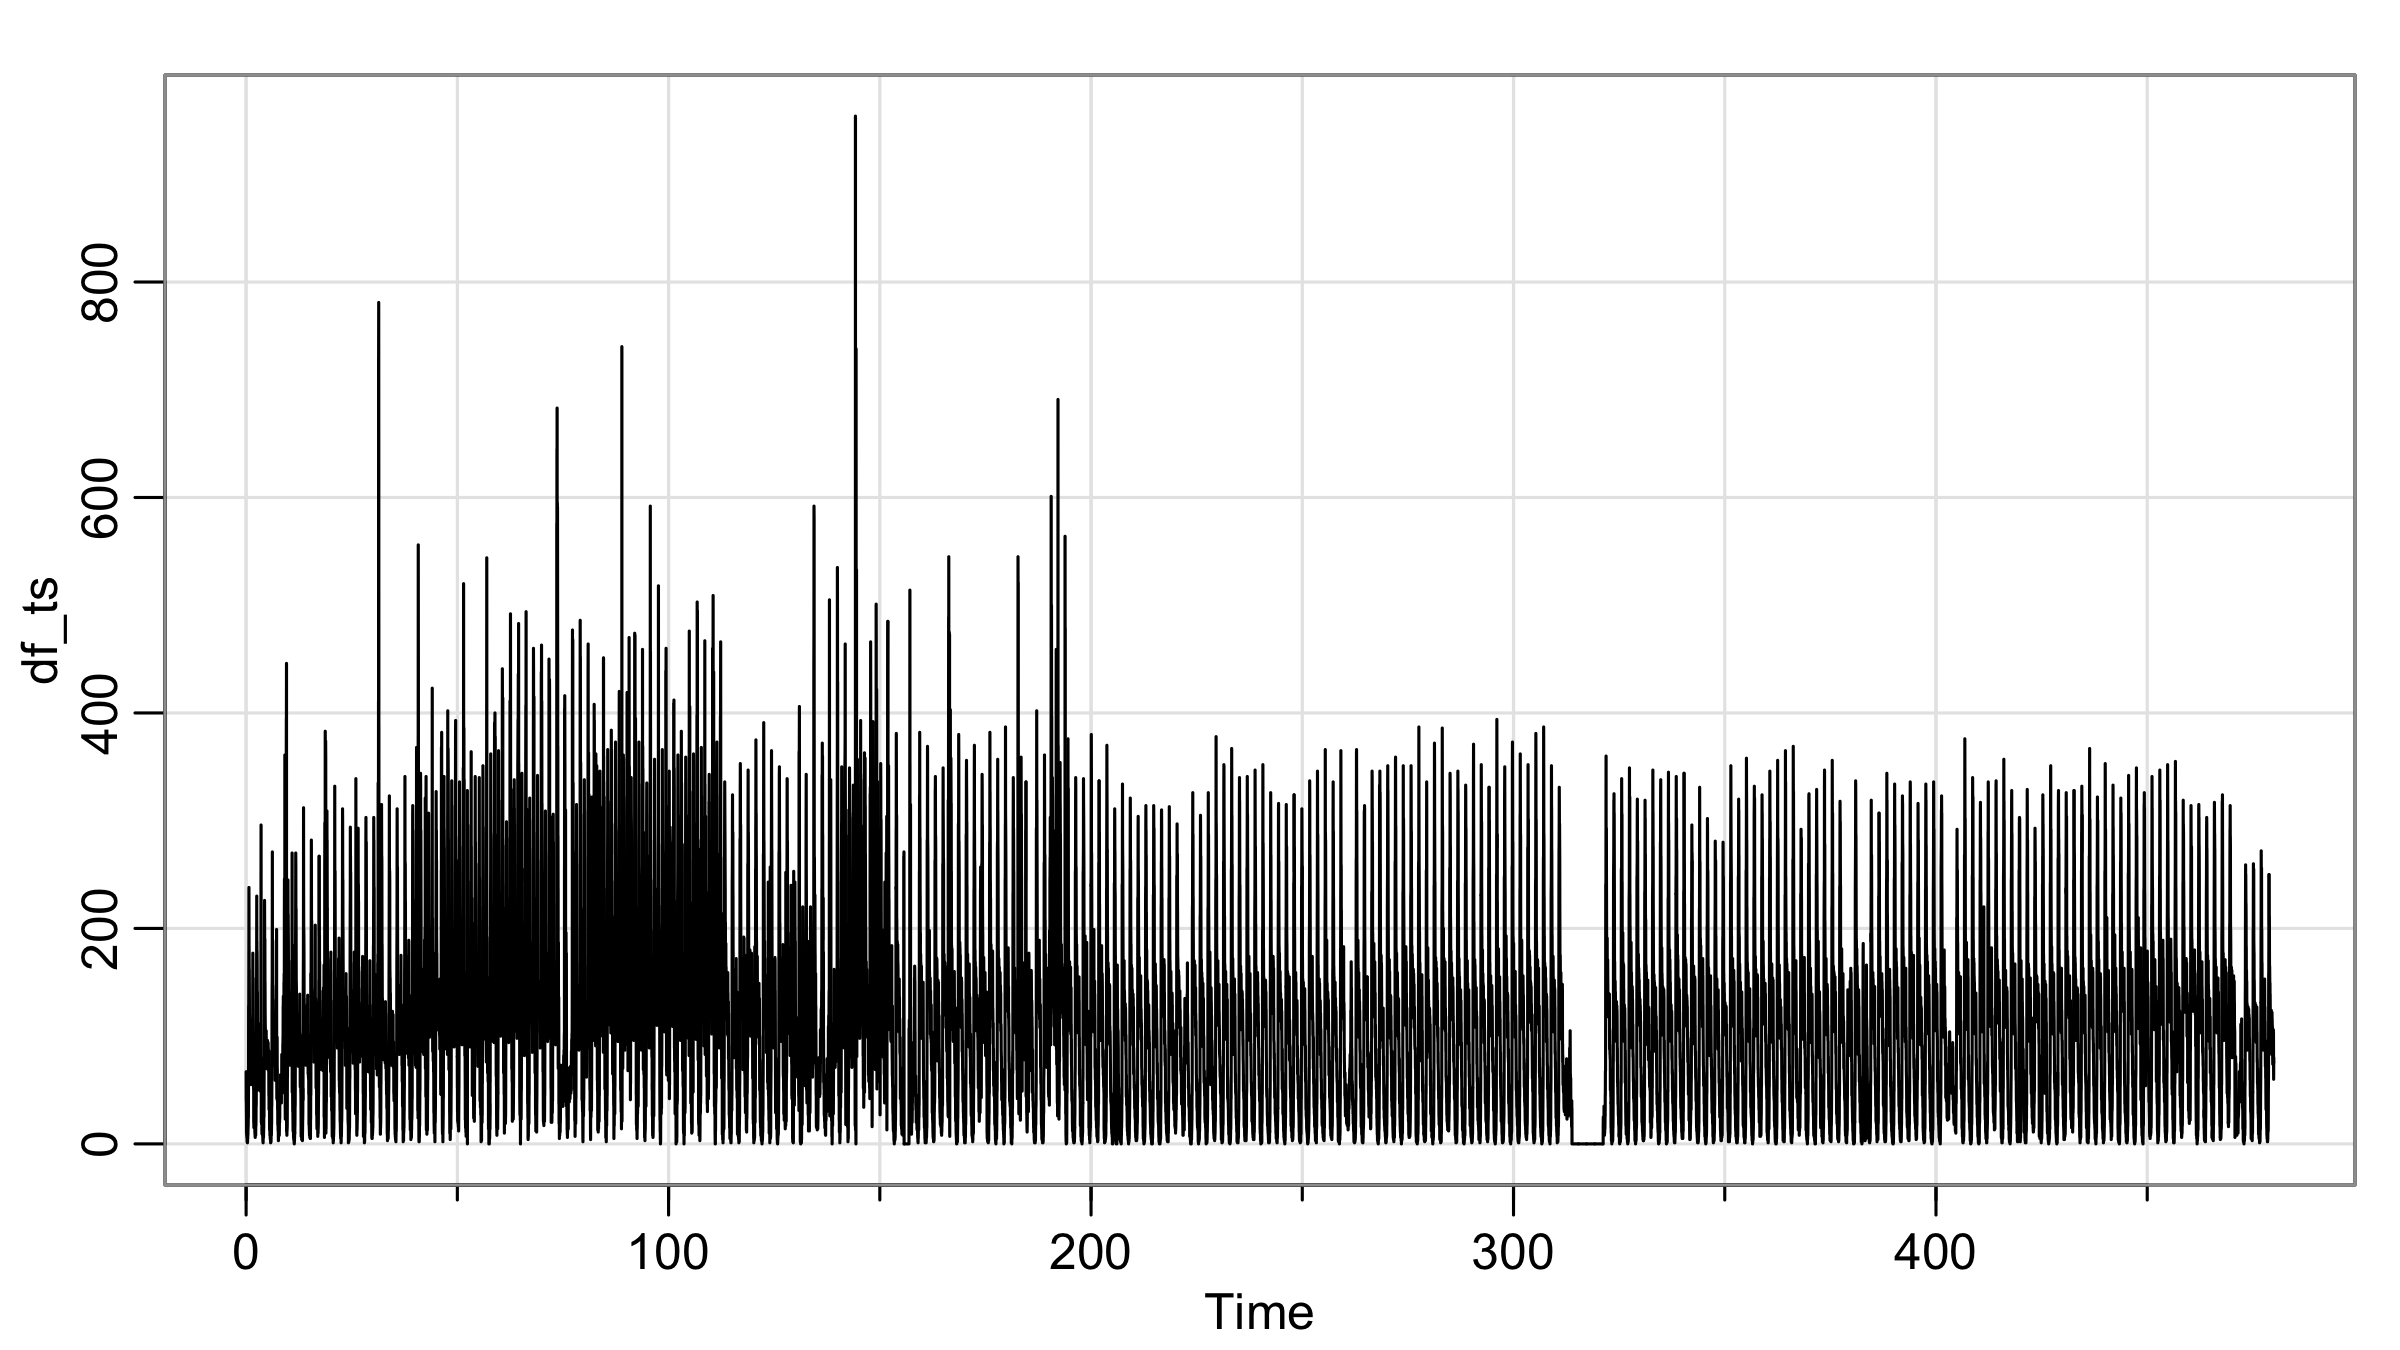

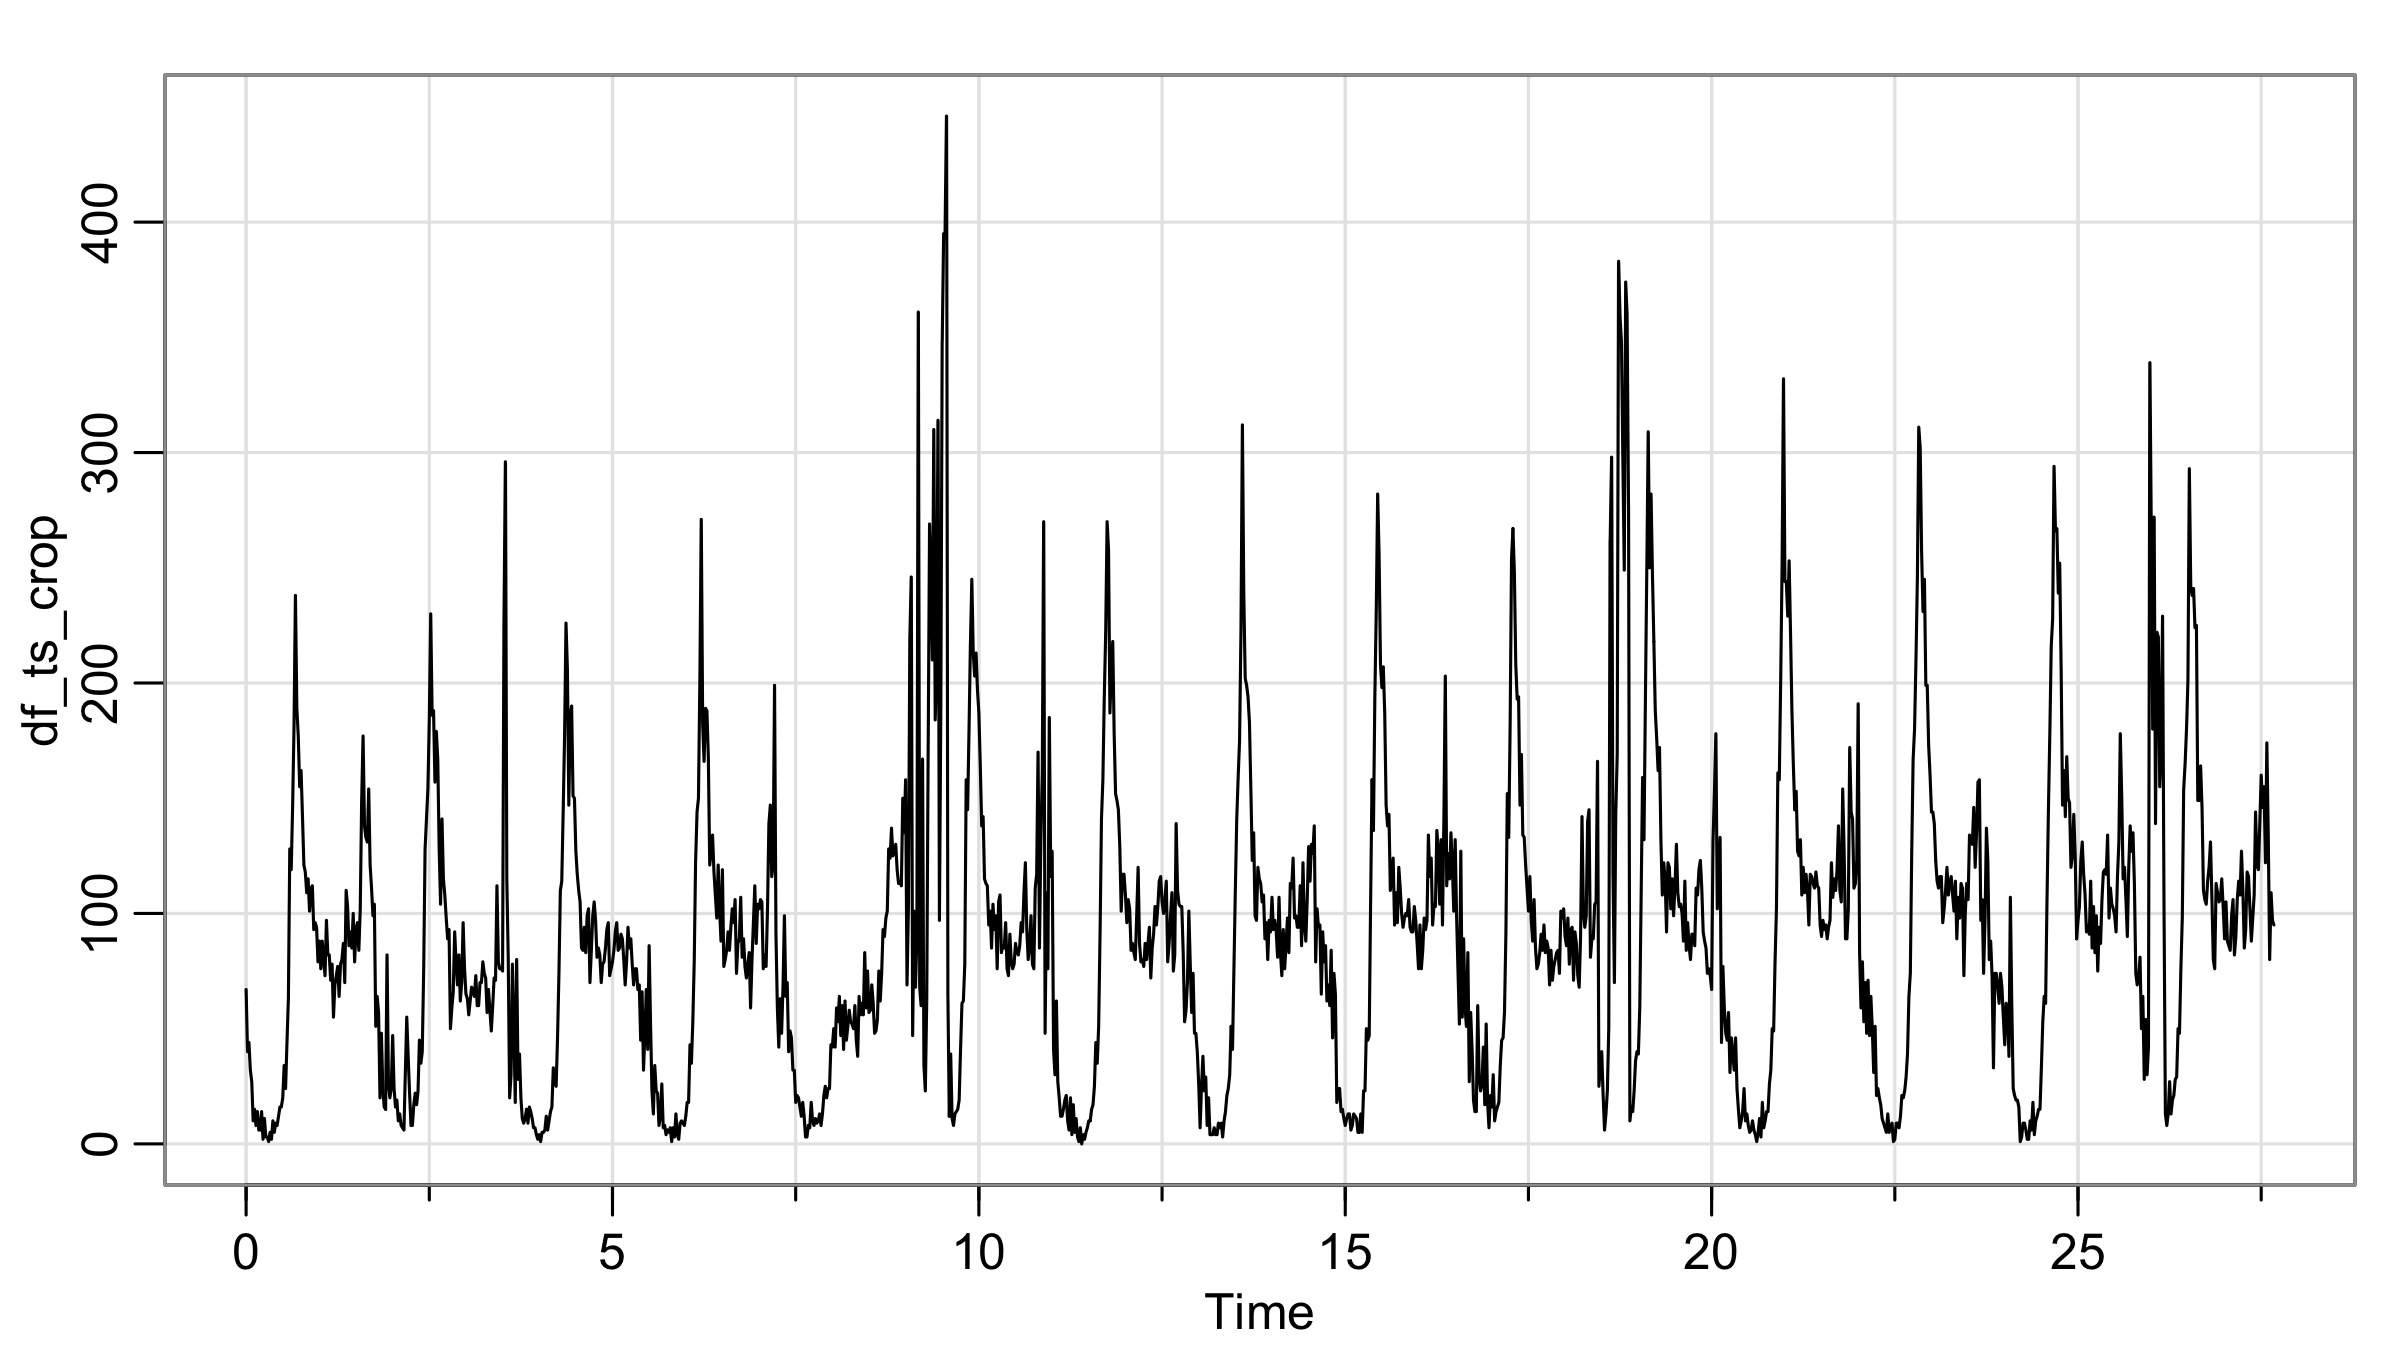

In [52]:
tsplot(df_ts)
days_to_crop = 15
samples_per_day = 96
df_ts_crop = head(df_ts, samples_per_day*days_to_crop)
mean(df_ts_crop)
tsplot(df_ts_crop)


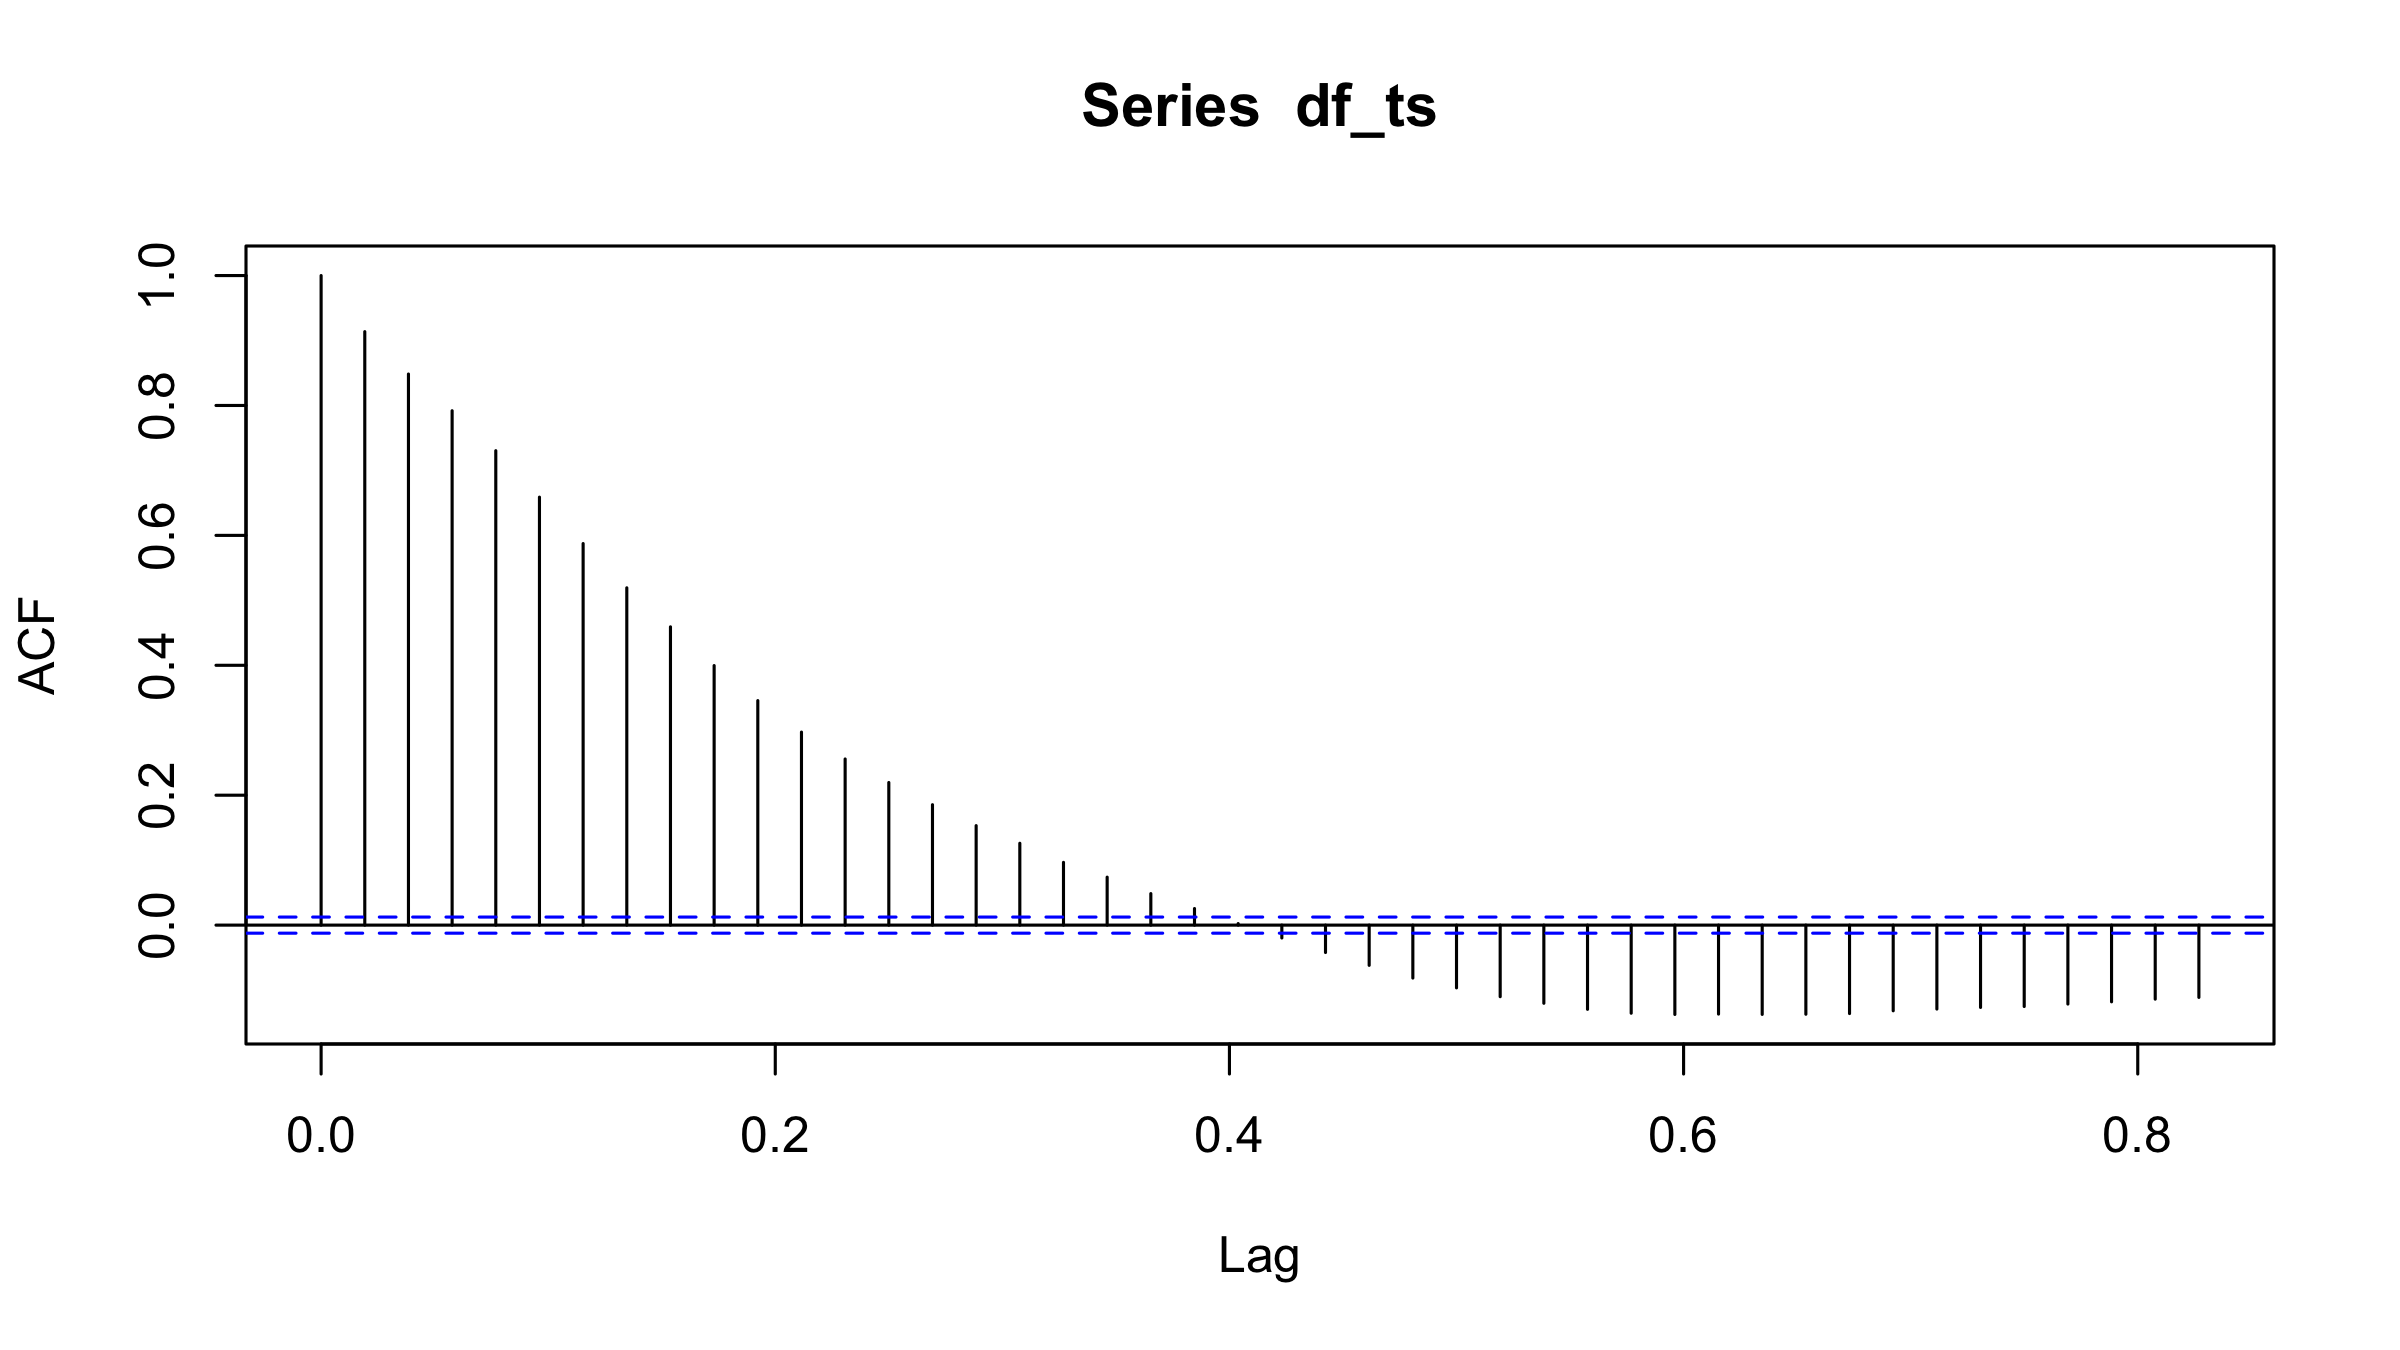

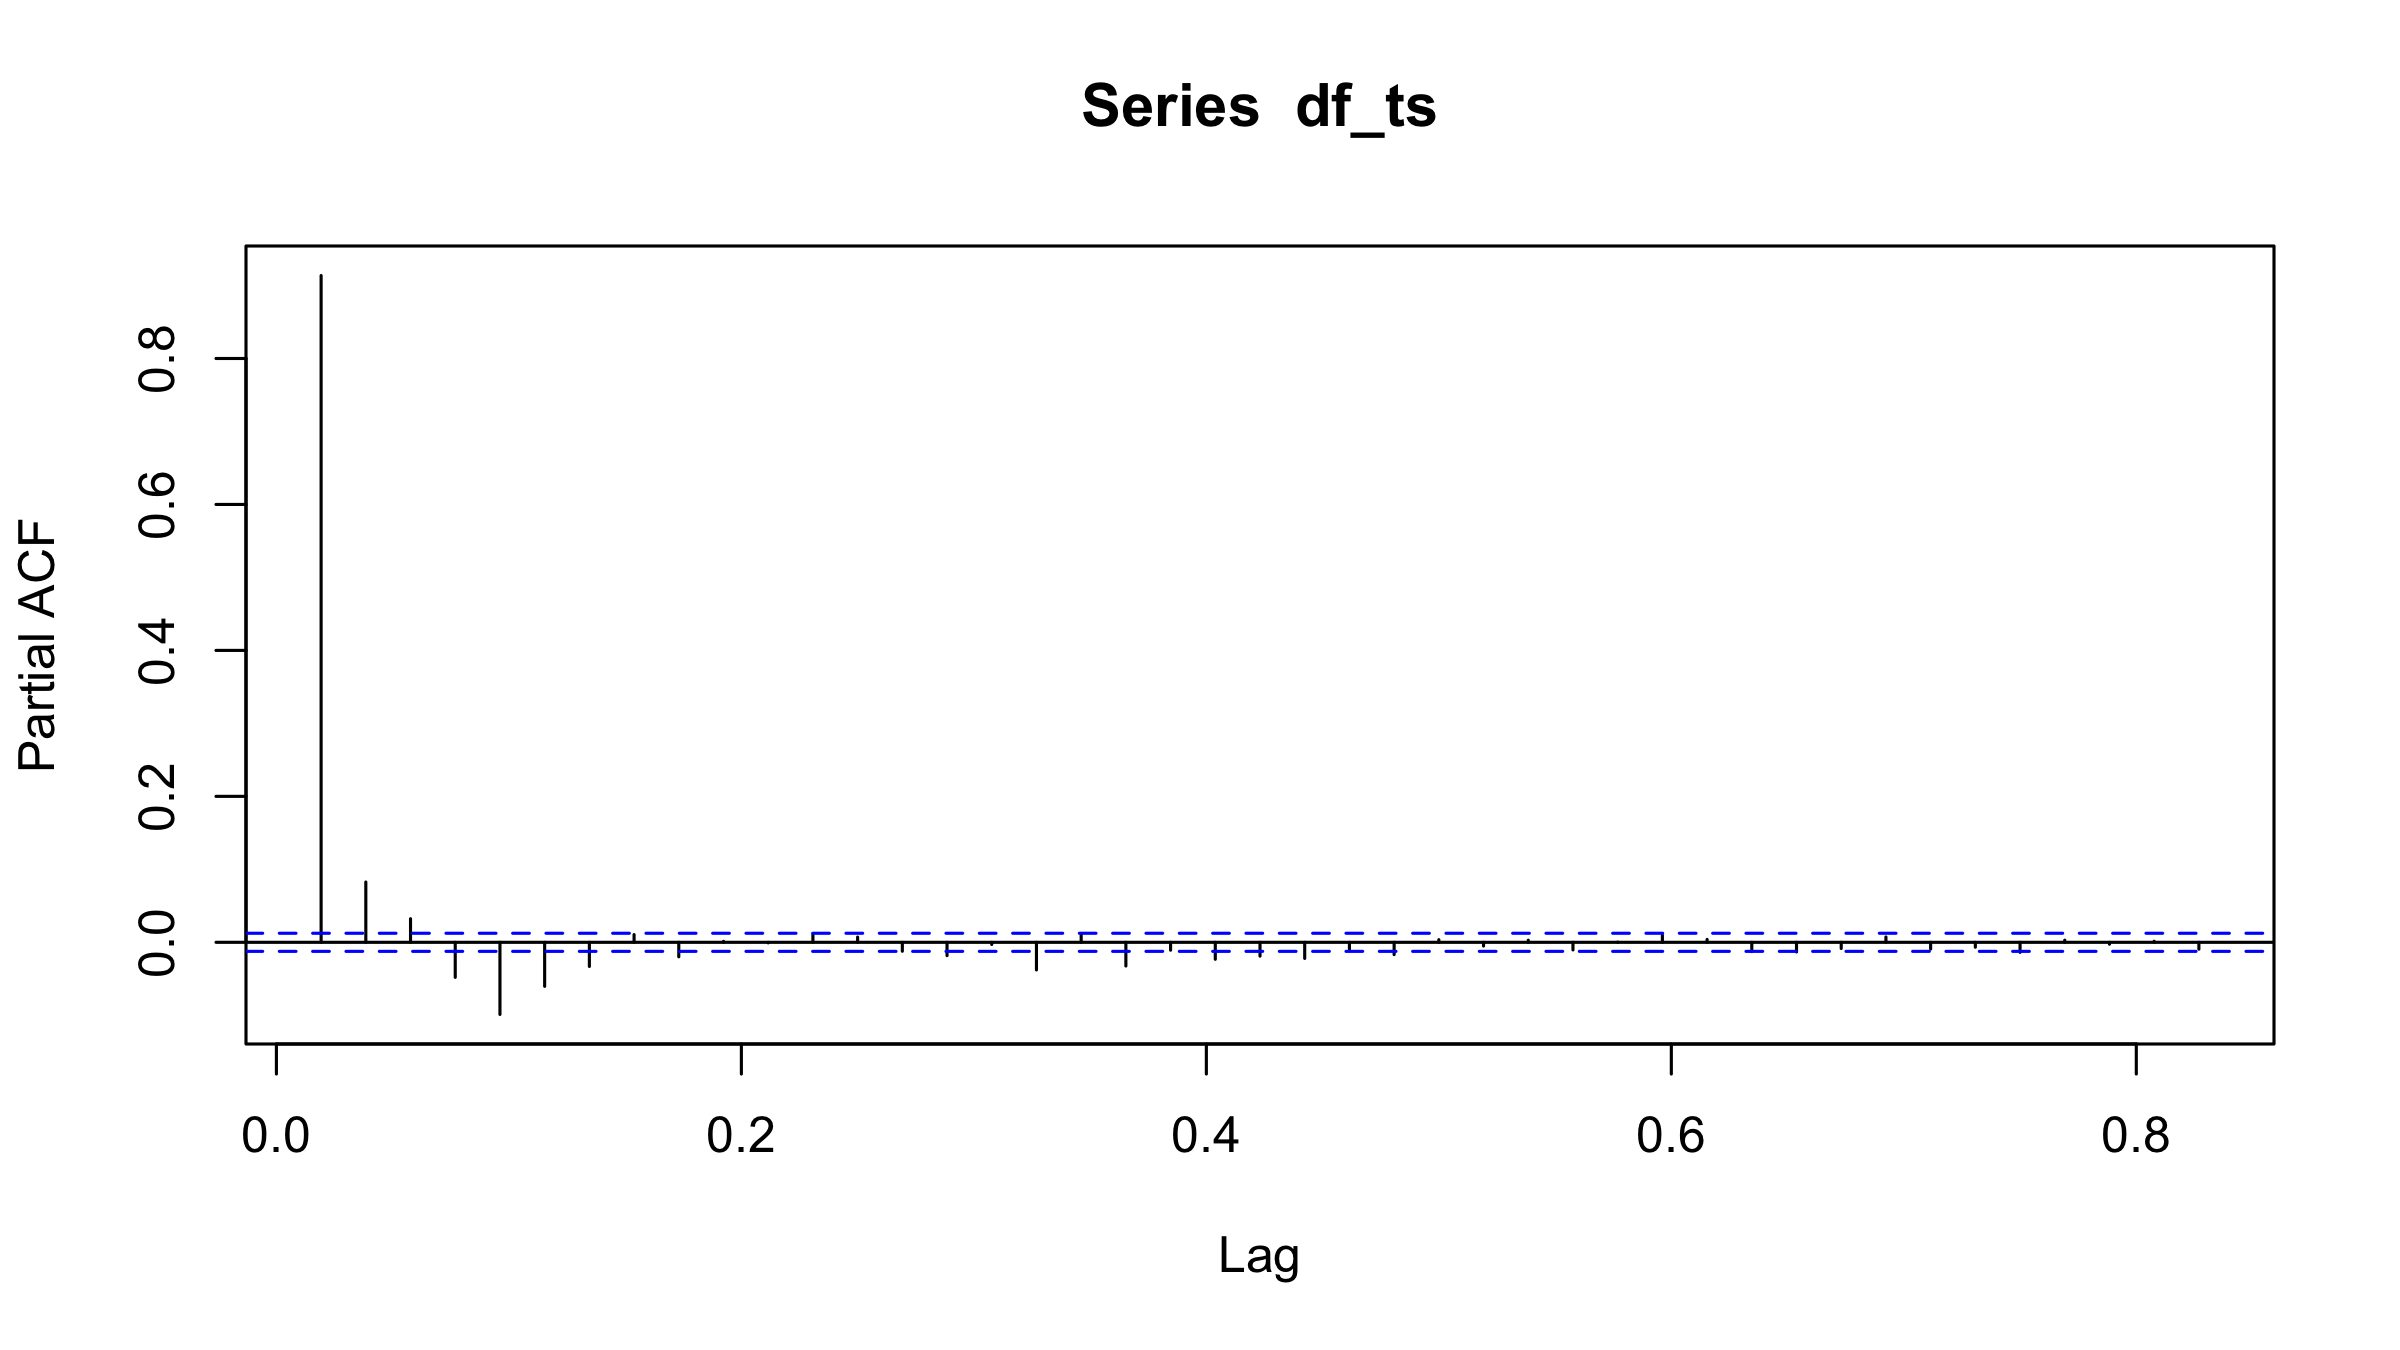

In [67]:
acf(df_ts)
pacf(df_ts)

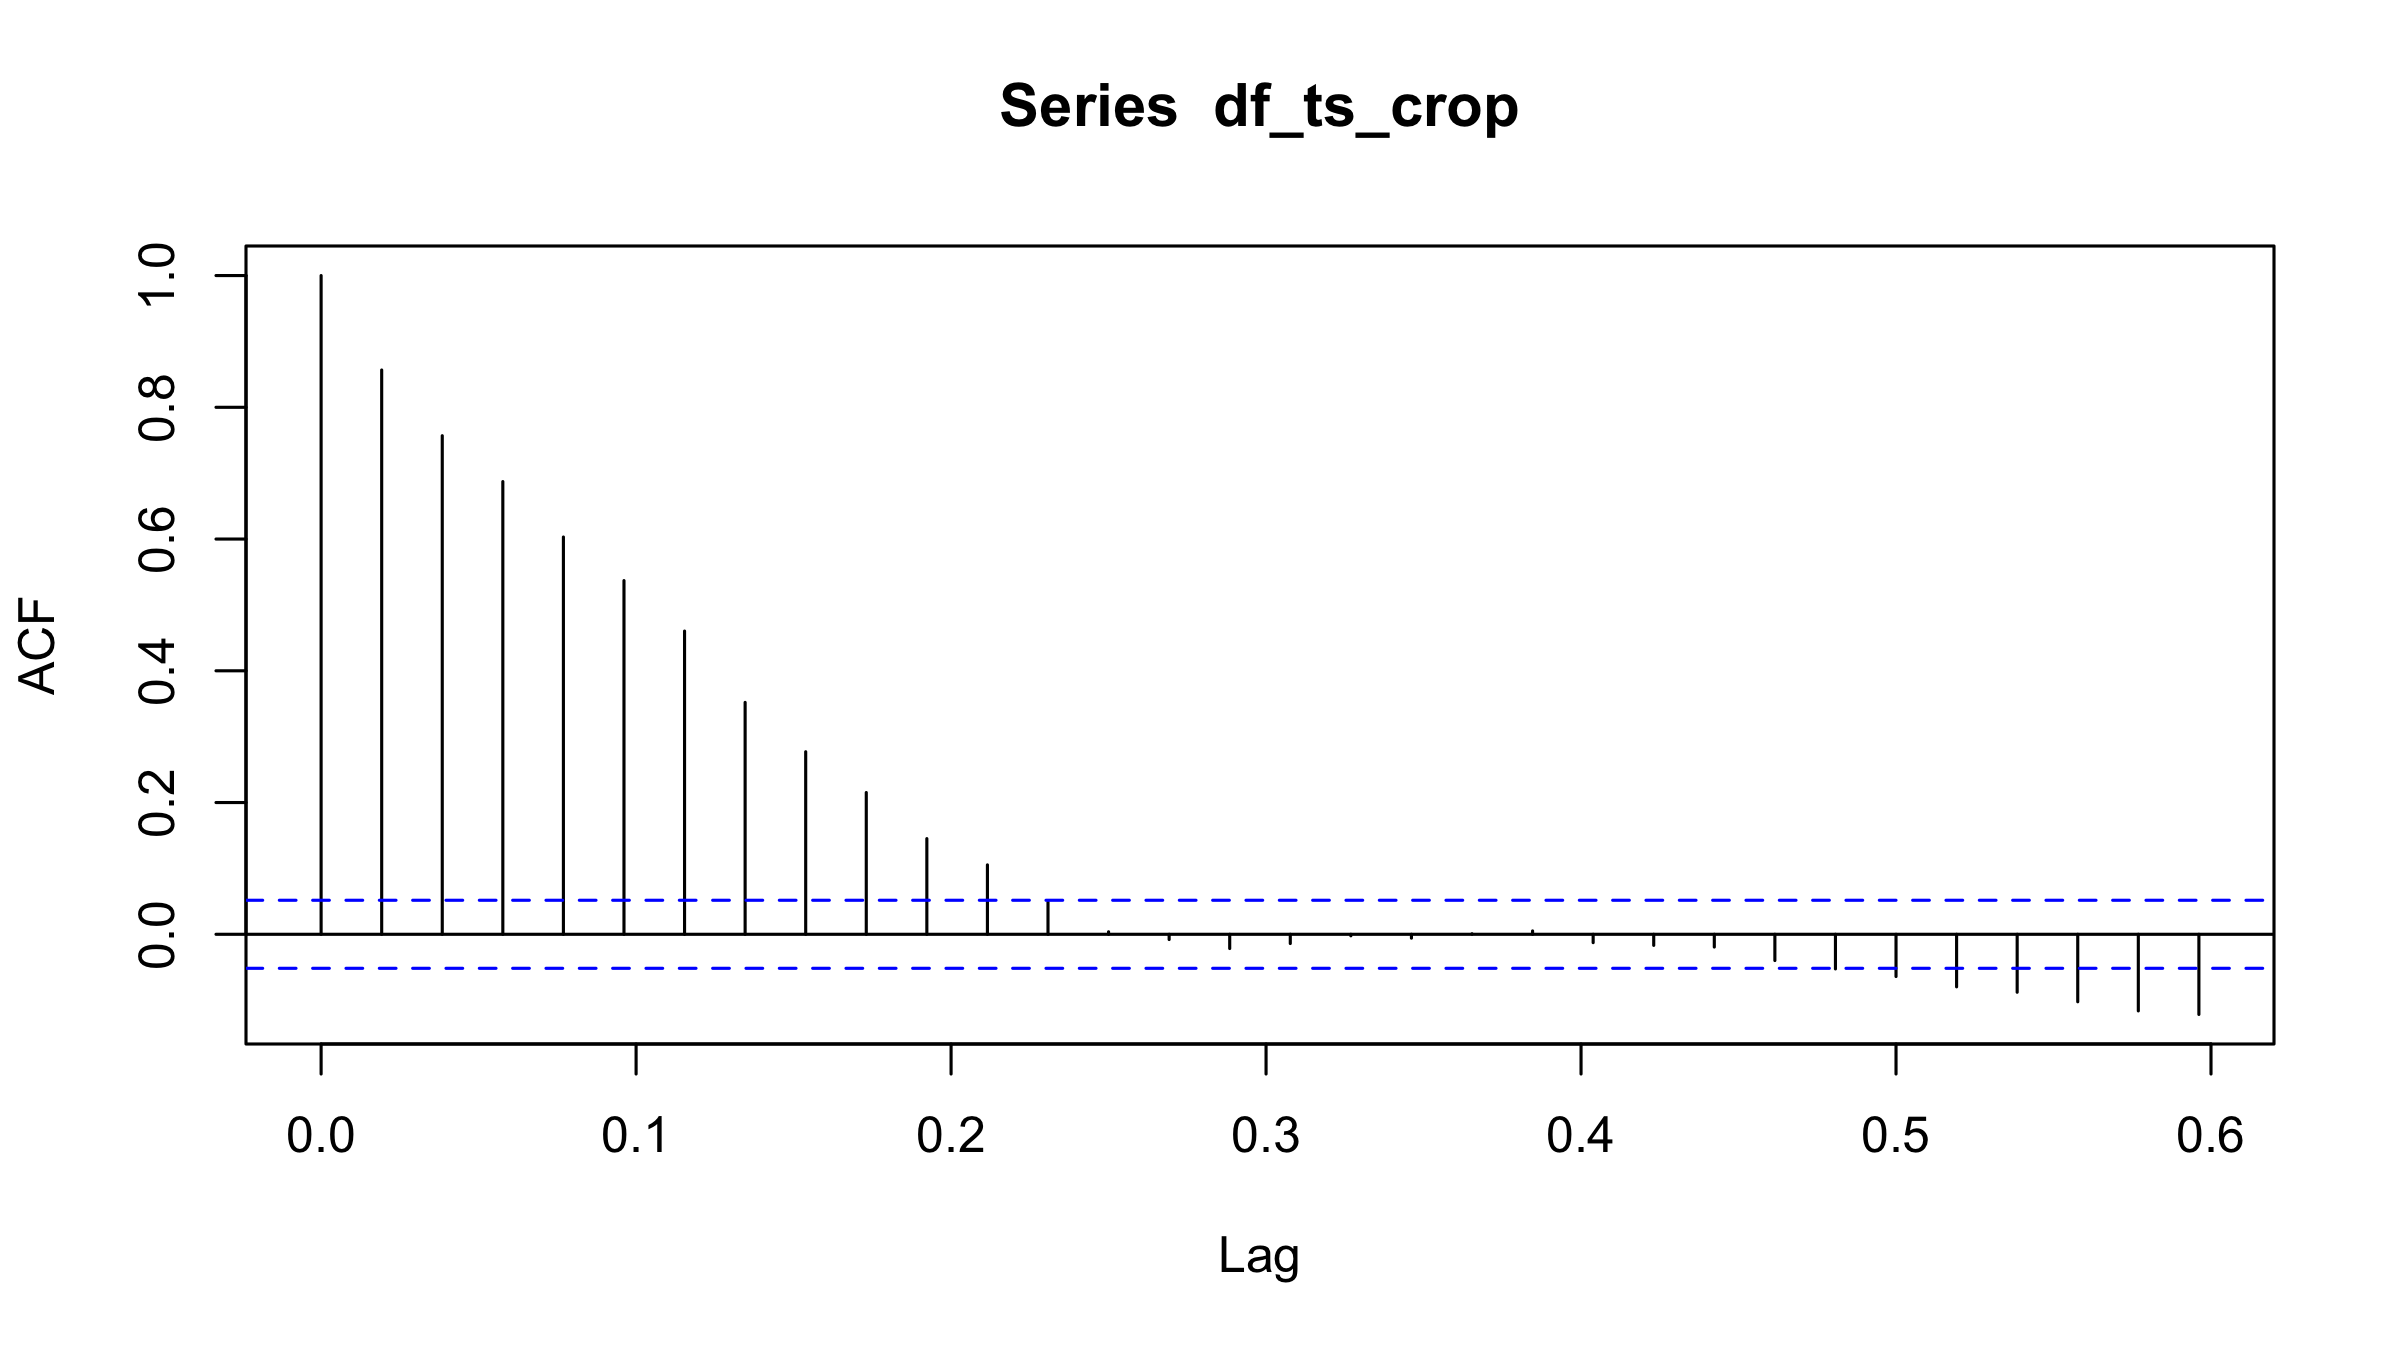

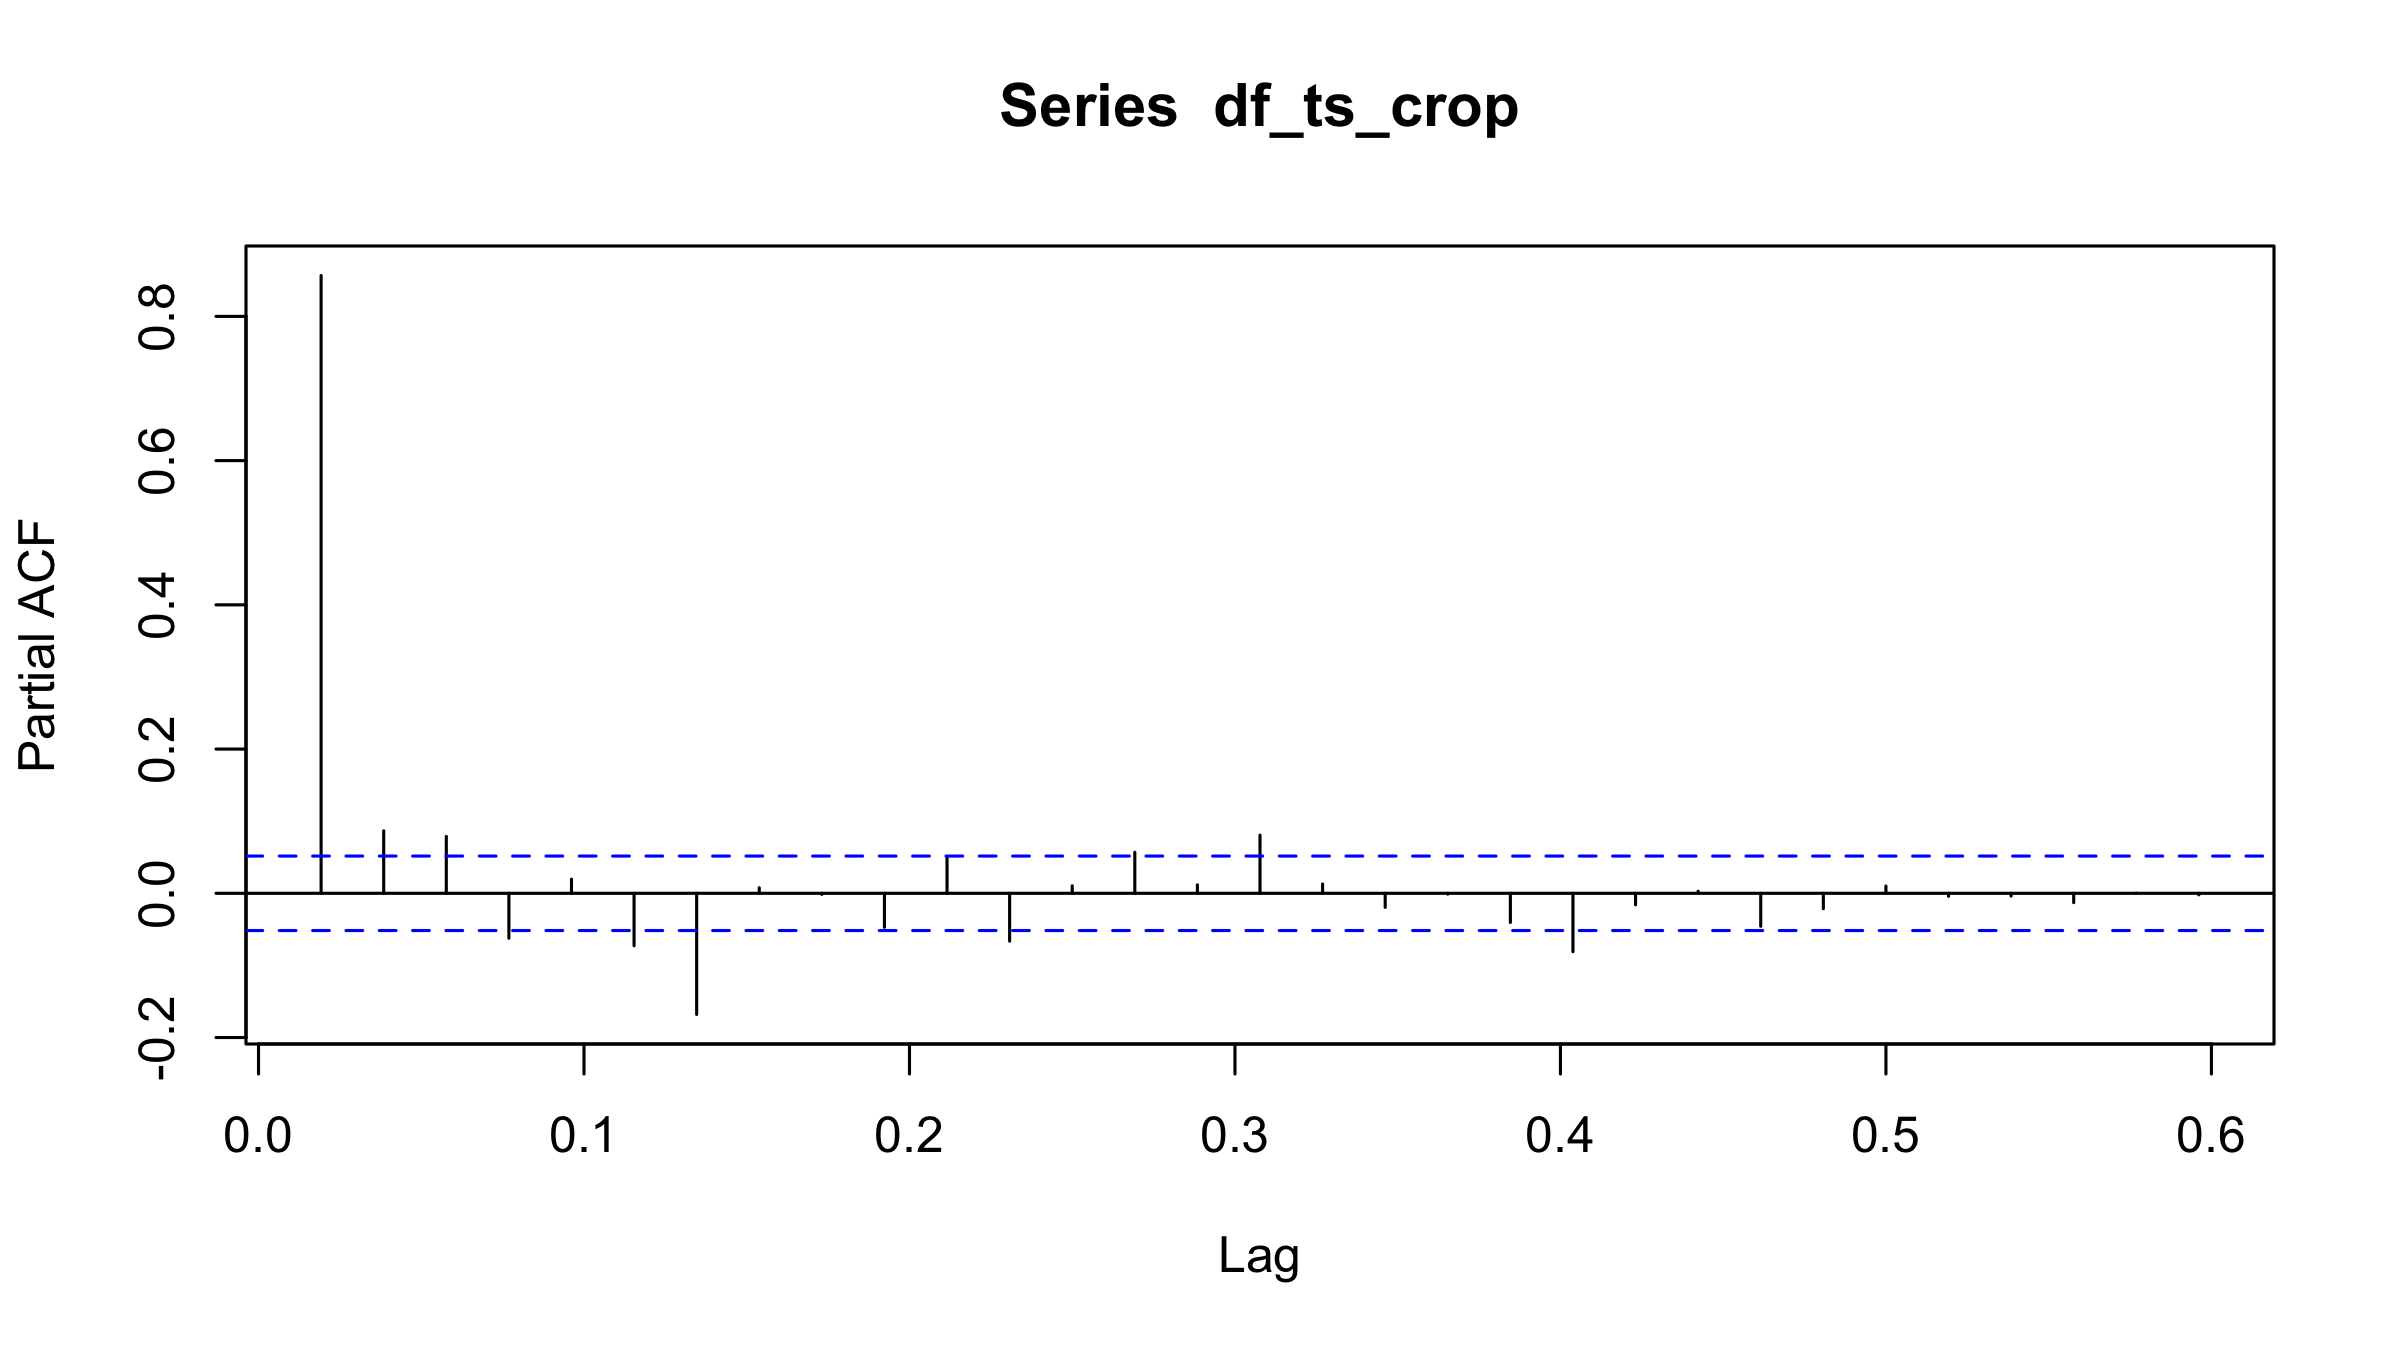

In [53]:
acf(df_ts_crop)
pacf(df_ts_crop)

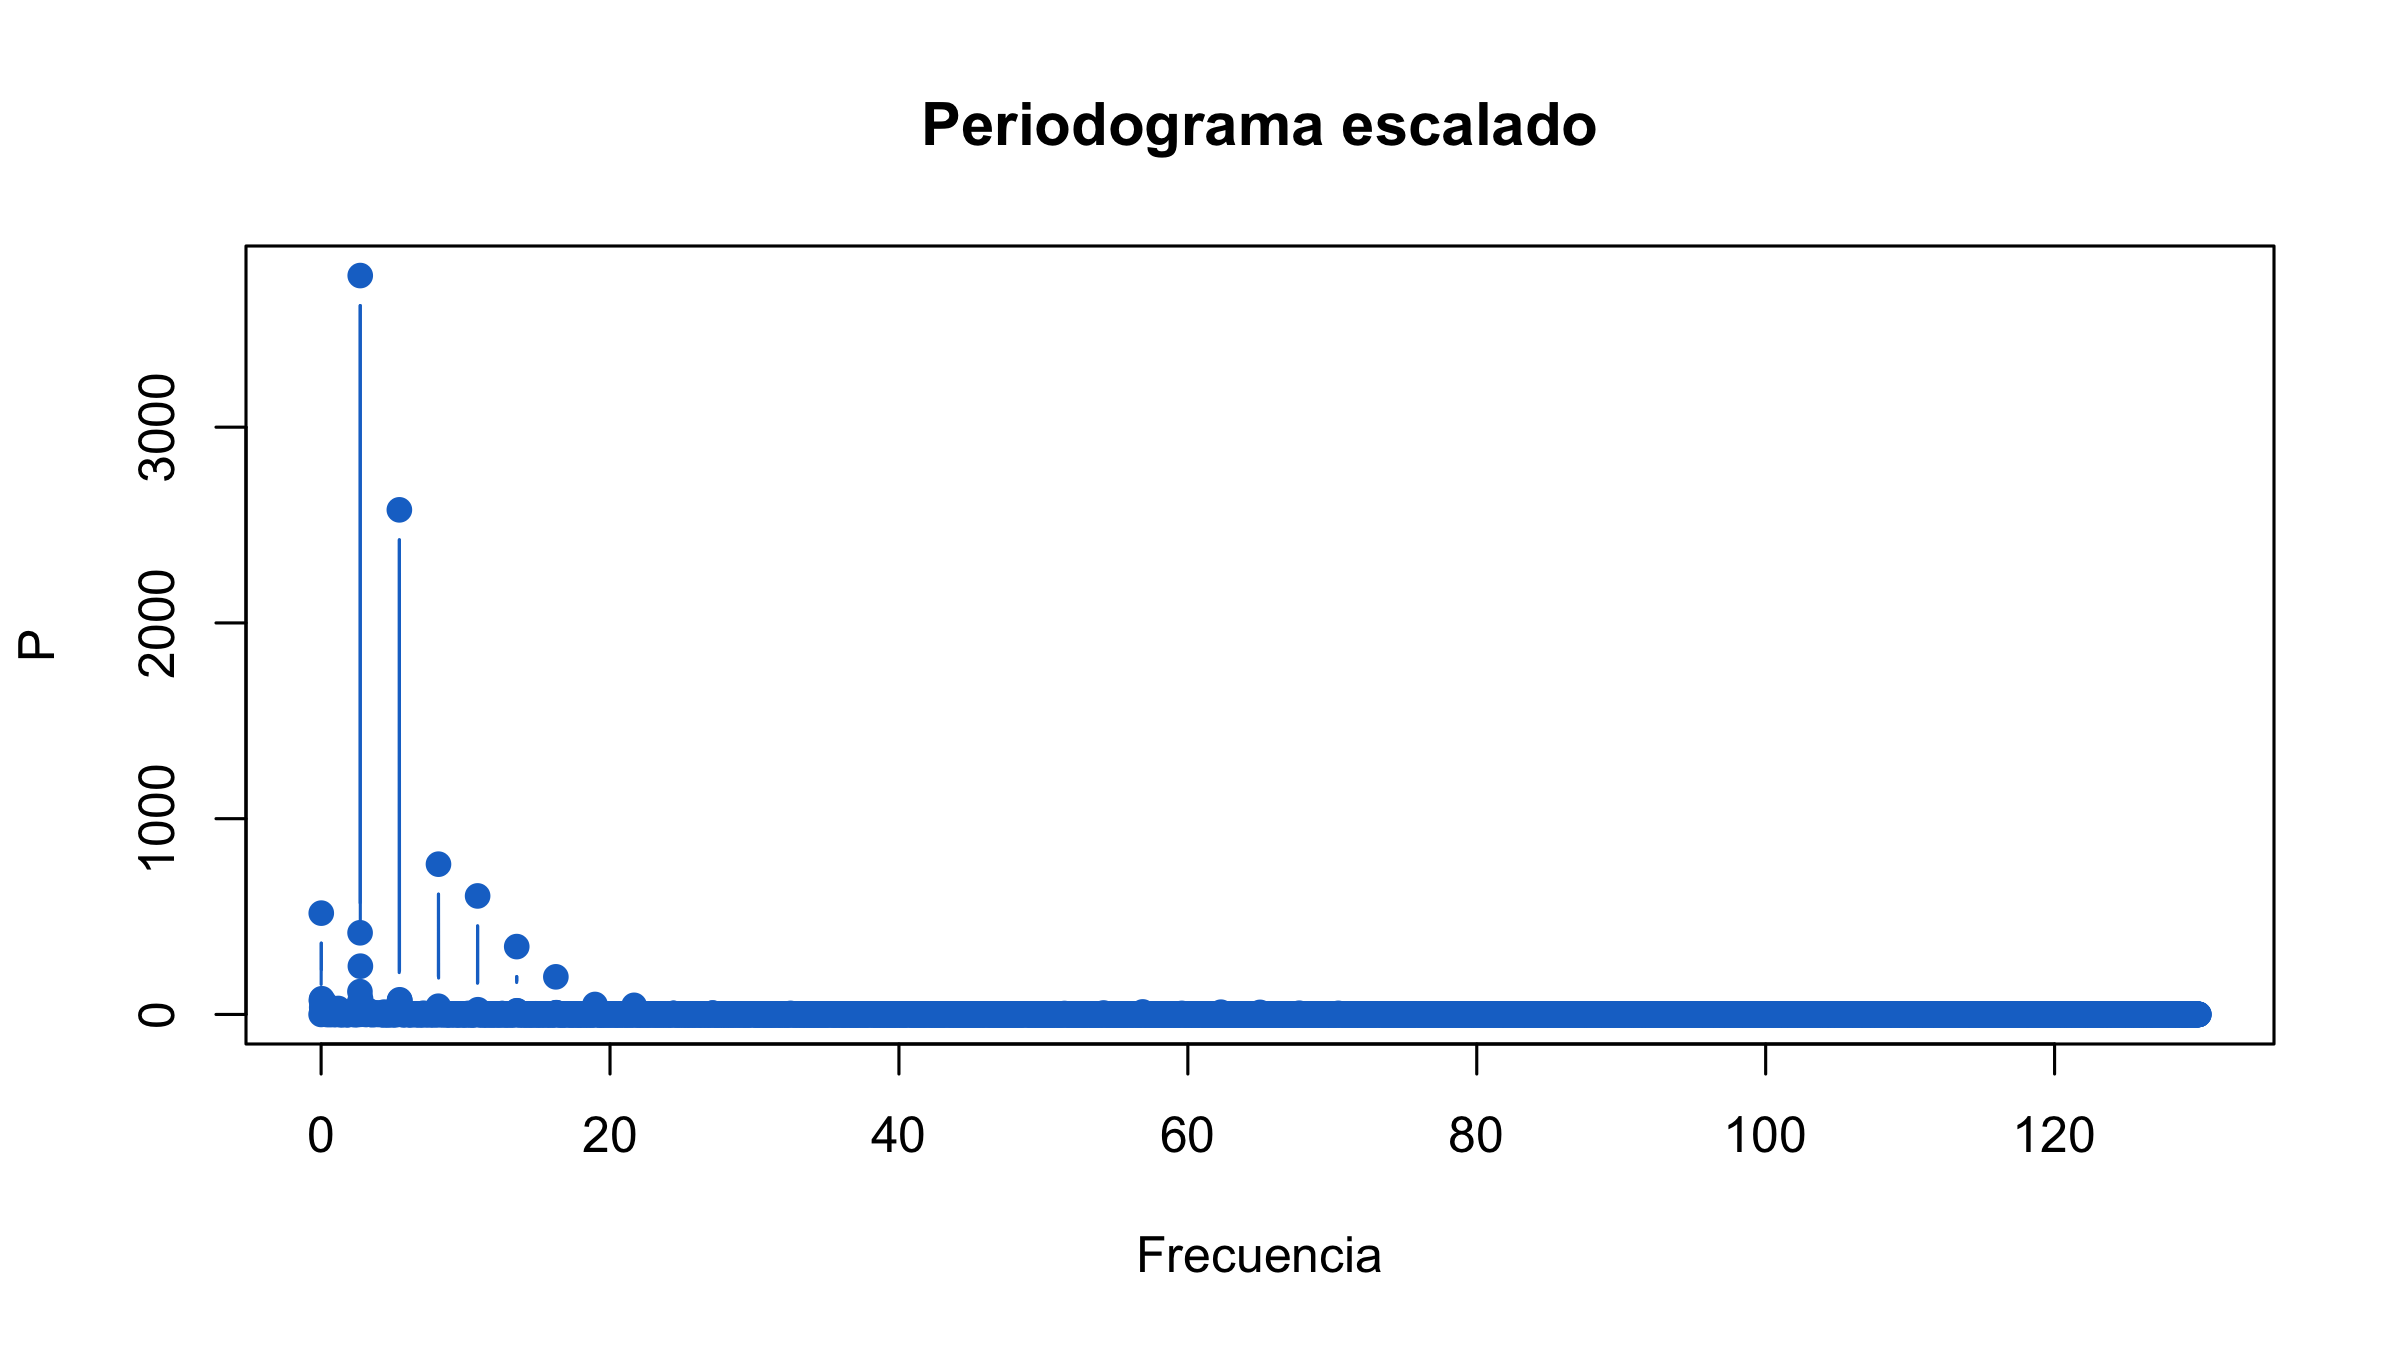

In [6]:
# Estudio de la periodicidad 
freq_periodograma = (24*60)/(3*5) # 24 horas * 60 minutos es la granularidad de minutos por día sobre 3 carriles * 5 minutos por muestra
s = df_ts
s = s-mean(s) # Se quita la media
n = length(s)
I = abs(fft(s))^2 #FFT y módulo cuadrado
I = I[1:floor(n/2)] #Recorto el vector a las frecuencias observables
P = (4/n^2)*I #Escalado del periodograma
f = (0:(n/2-1))/n*freq/96 #Vector de frecuencias para hacer el gráfico (se multiplica por la frecuencia de la serie, para normalizar

#Ploteo del periodograma
plot(f, P, type="b", xlab="Frecuencia", main="Periodograma escalado", col=4, lwd=1, pch=19)

In [7]:
f1 = f[which.max(P)]*samples_per_day
f1
P[which.max(P)] = 0
f2 = f[which.max(P)]*samples_per_day
f2
P[which.max(P)] = 0
f3 = f[which.max(P)]*samples_per_day
f3

[1] 260

[1] 520

[1] 780


Call:
lm(formula = df_ts_crop ~ t + cos(2 * pi * f1 * t) + sin(2 * 
    pi * f1 * t) + cos(2 * pi * f2 * t) + sin(2 * pi * f2 * t) + 
    cos(2 * pi * f3 * t) + sin(2 * pi * f3 * t))

Residuals:
    Min      1Q  Median      3Q     Max 
-120.55  -28.37   -9.74   13.85  427.83 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            70.900      2.783  25.479  < 2e-16 ***
t                     715.428     83.624   8.555  < 2e-16 ***
cos(2 * pi * f1 * t)  -29.806      1.966 -15.161  < 2e-16 ***
sin(2 * pi * f1 * t)   -9.046      1.969  -4.595 4.70e-06 ***
cos(2 * pi * f2 * t)    9.547      1.966   4.856 1.33e-06 ***
sin(2 * pi * f2 * t)  -38.620      1.967 -19.638  < 2e-16 ***
cos(2 * pi * f3 * t)    5.630      1.966   2.864  0.00425 ** 
sin(2 * pi * f3 * t)   18.991      1.966   9.659  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.75 on 1432 degrees of freedom
Multiple R-squared:  0.

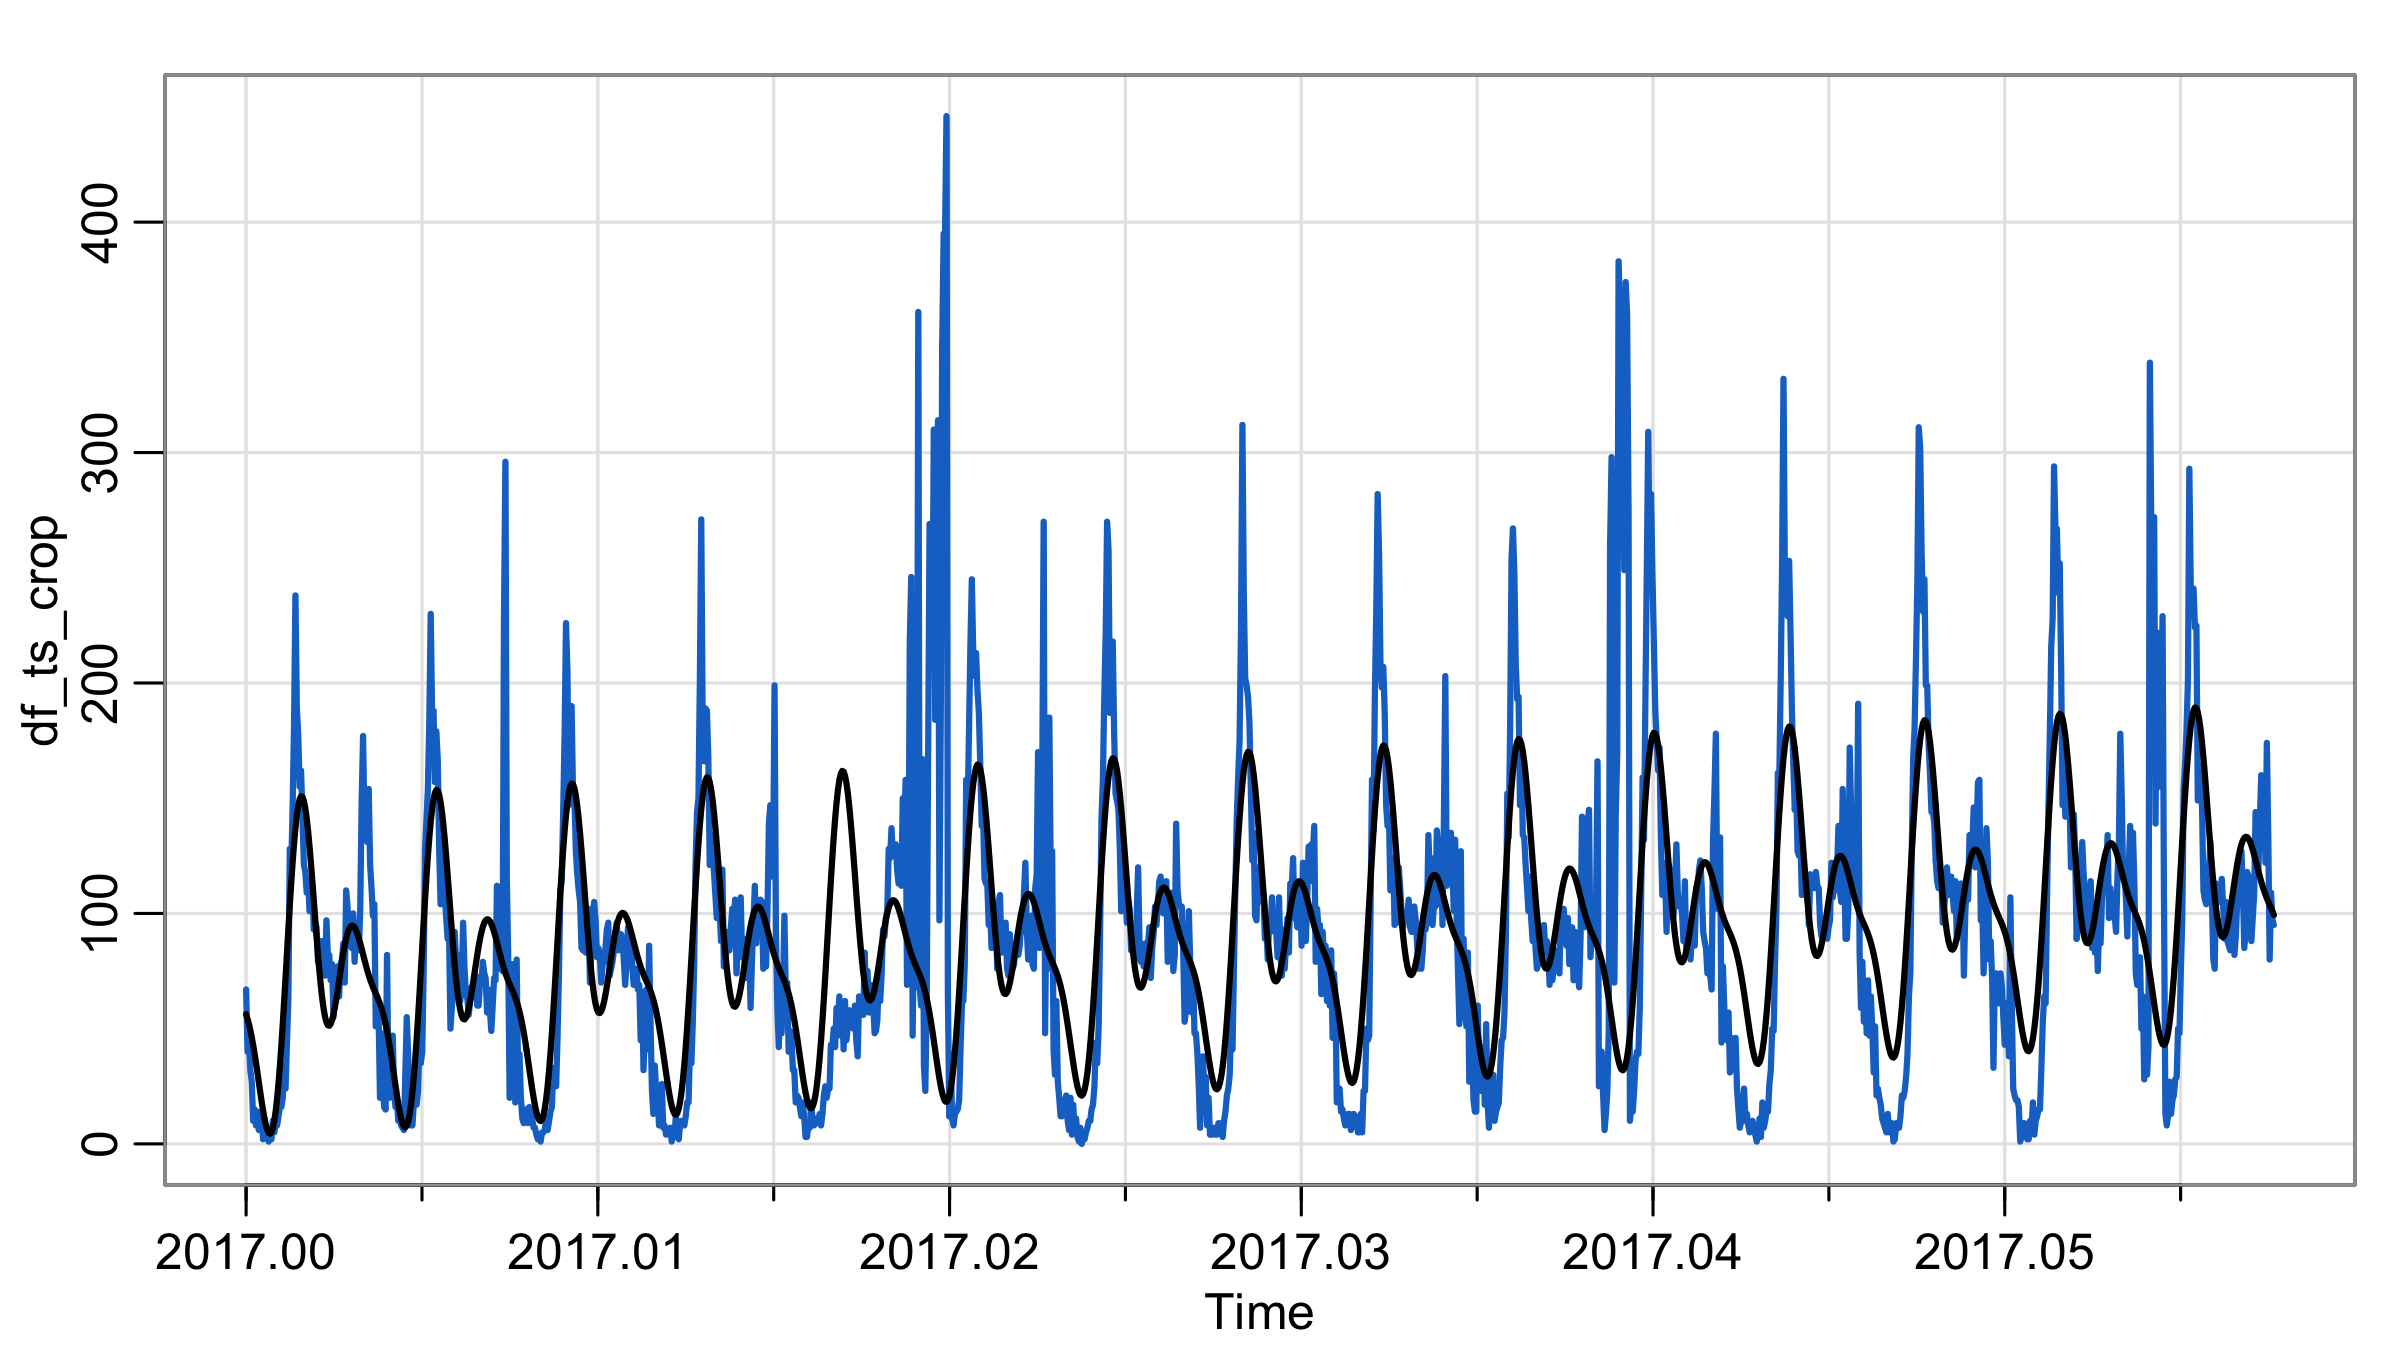

In [27]:
t = time(df_ts_crop)-2017
#seasonal_fit = lm(df_ts_crop ~ t + cos(2*pi*f*t)+sin(2*pi*f*t)+cos(4*pi*f*t)+sin(4*pi*f*t))
fit_df_ts_crop = lm(df_ts_crop ~ t + cos(2*pi*f1*t)+sin(2*pi*f1*t)+cos(2*pi*f2*t)+sin(2*pi*f2*t)+cos(2*pi*f3*t)+sin(2*pi*f3*t))

summary(fit_df_ts_crop)

adjustment_fit_df_ts_crop = ts(fitted(fit_df_ts_crop), start=2017, freq=freq)
tsplot(df_ts_crop, col=4, lwd=2)
lines(adjustment_fit_df_ts_crop, lwd=2)

residuals_fit = residuals(fit_df_ts_crop)

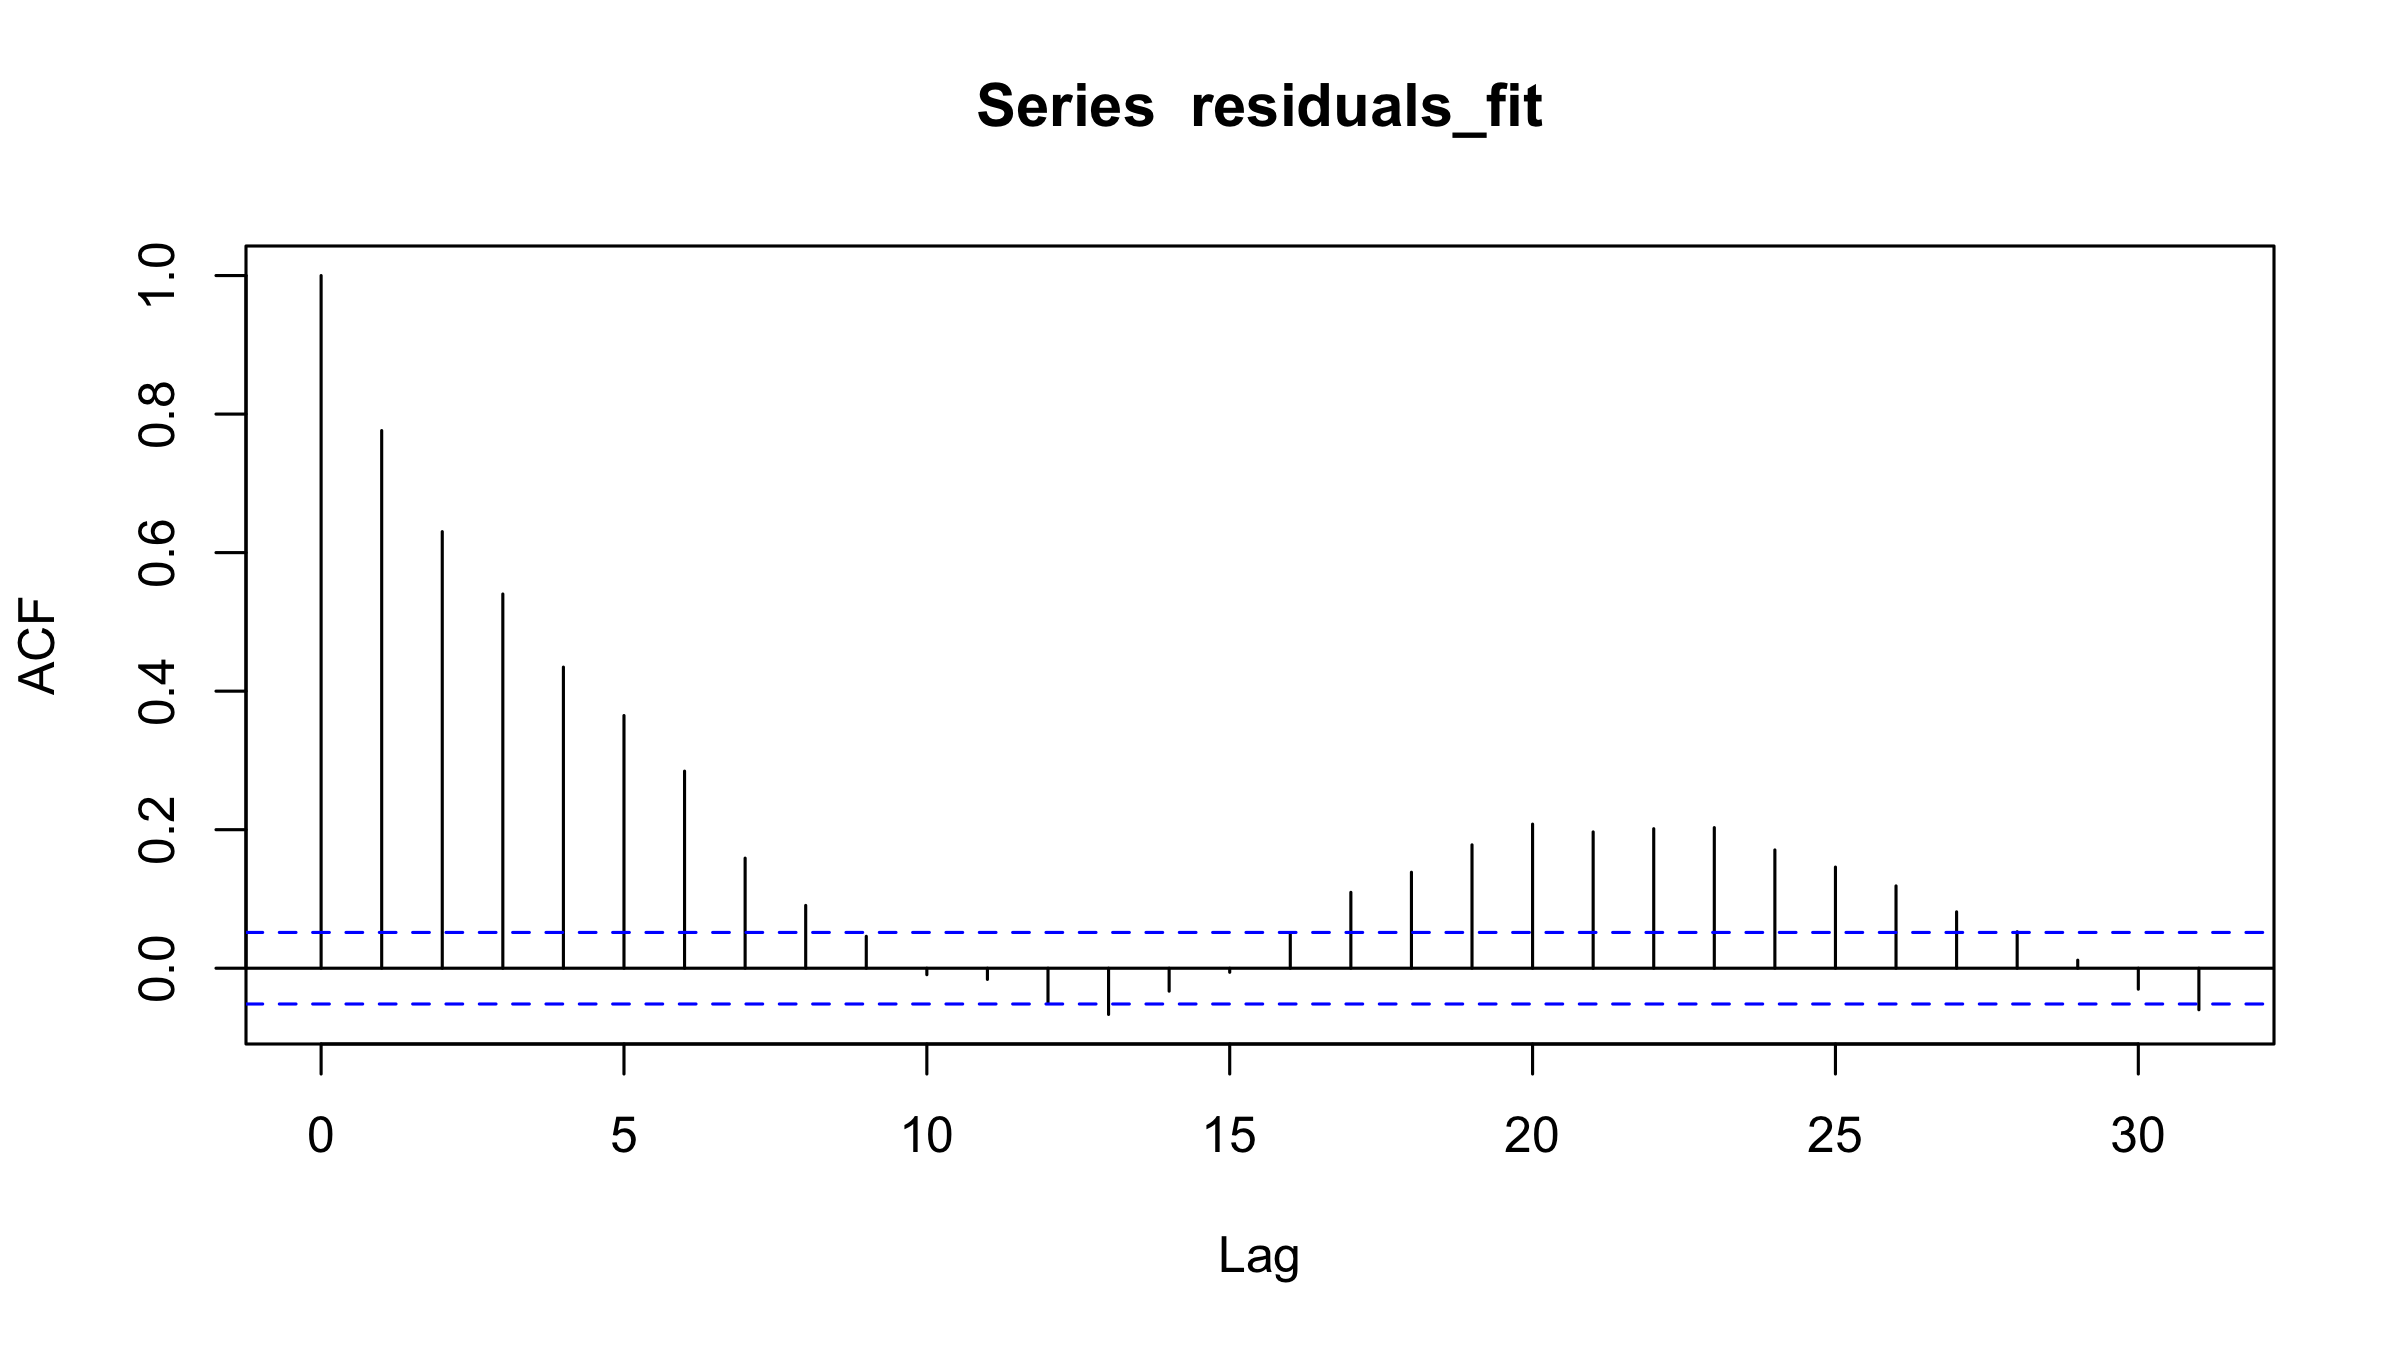

In [28]:
acf(residuals_fit)

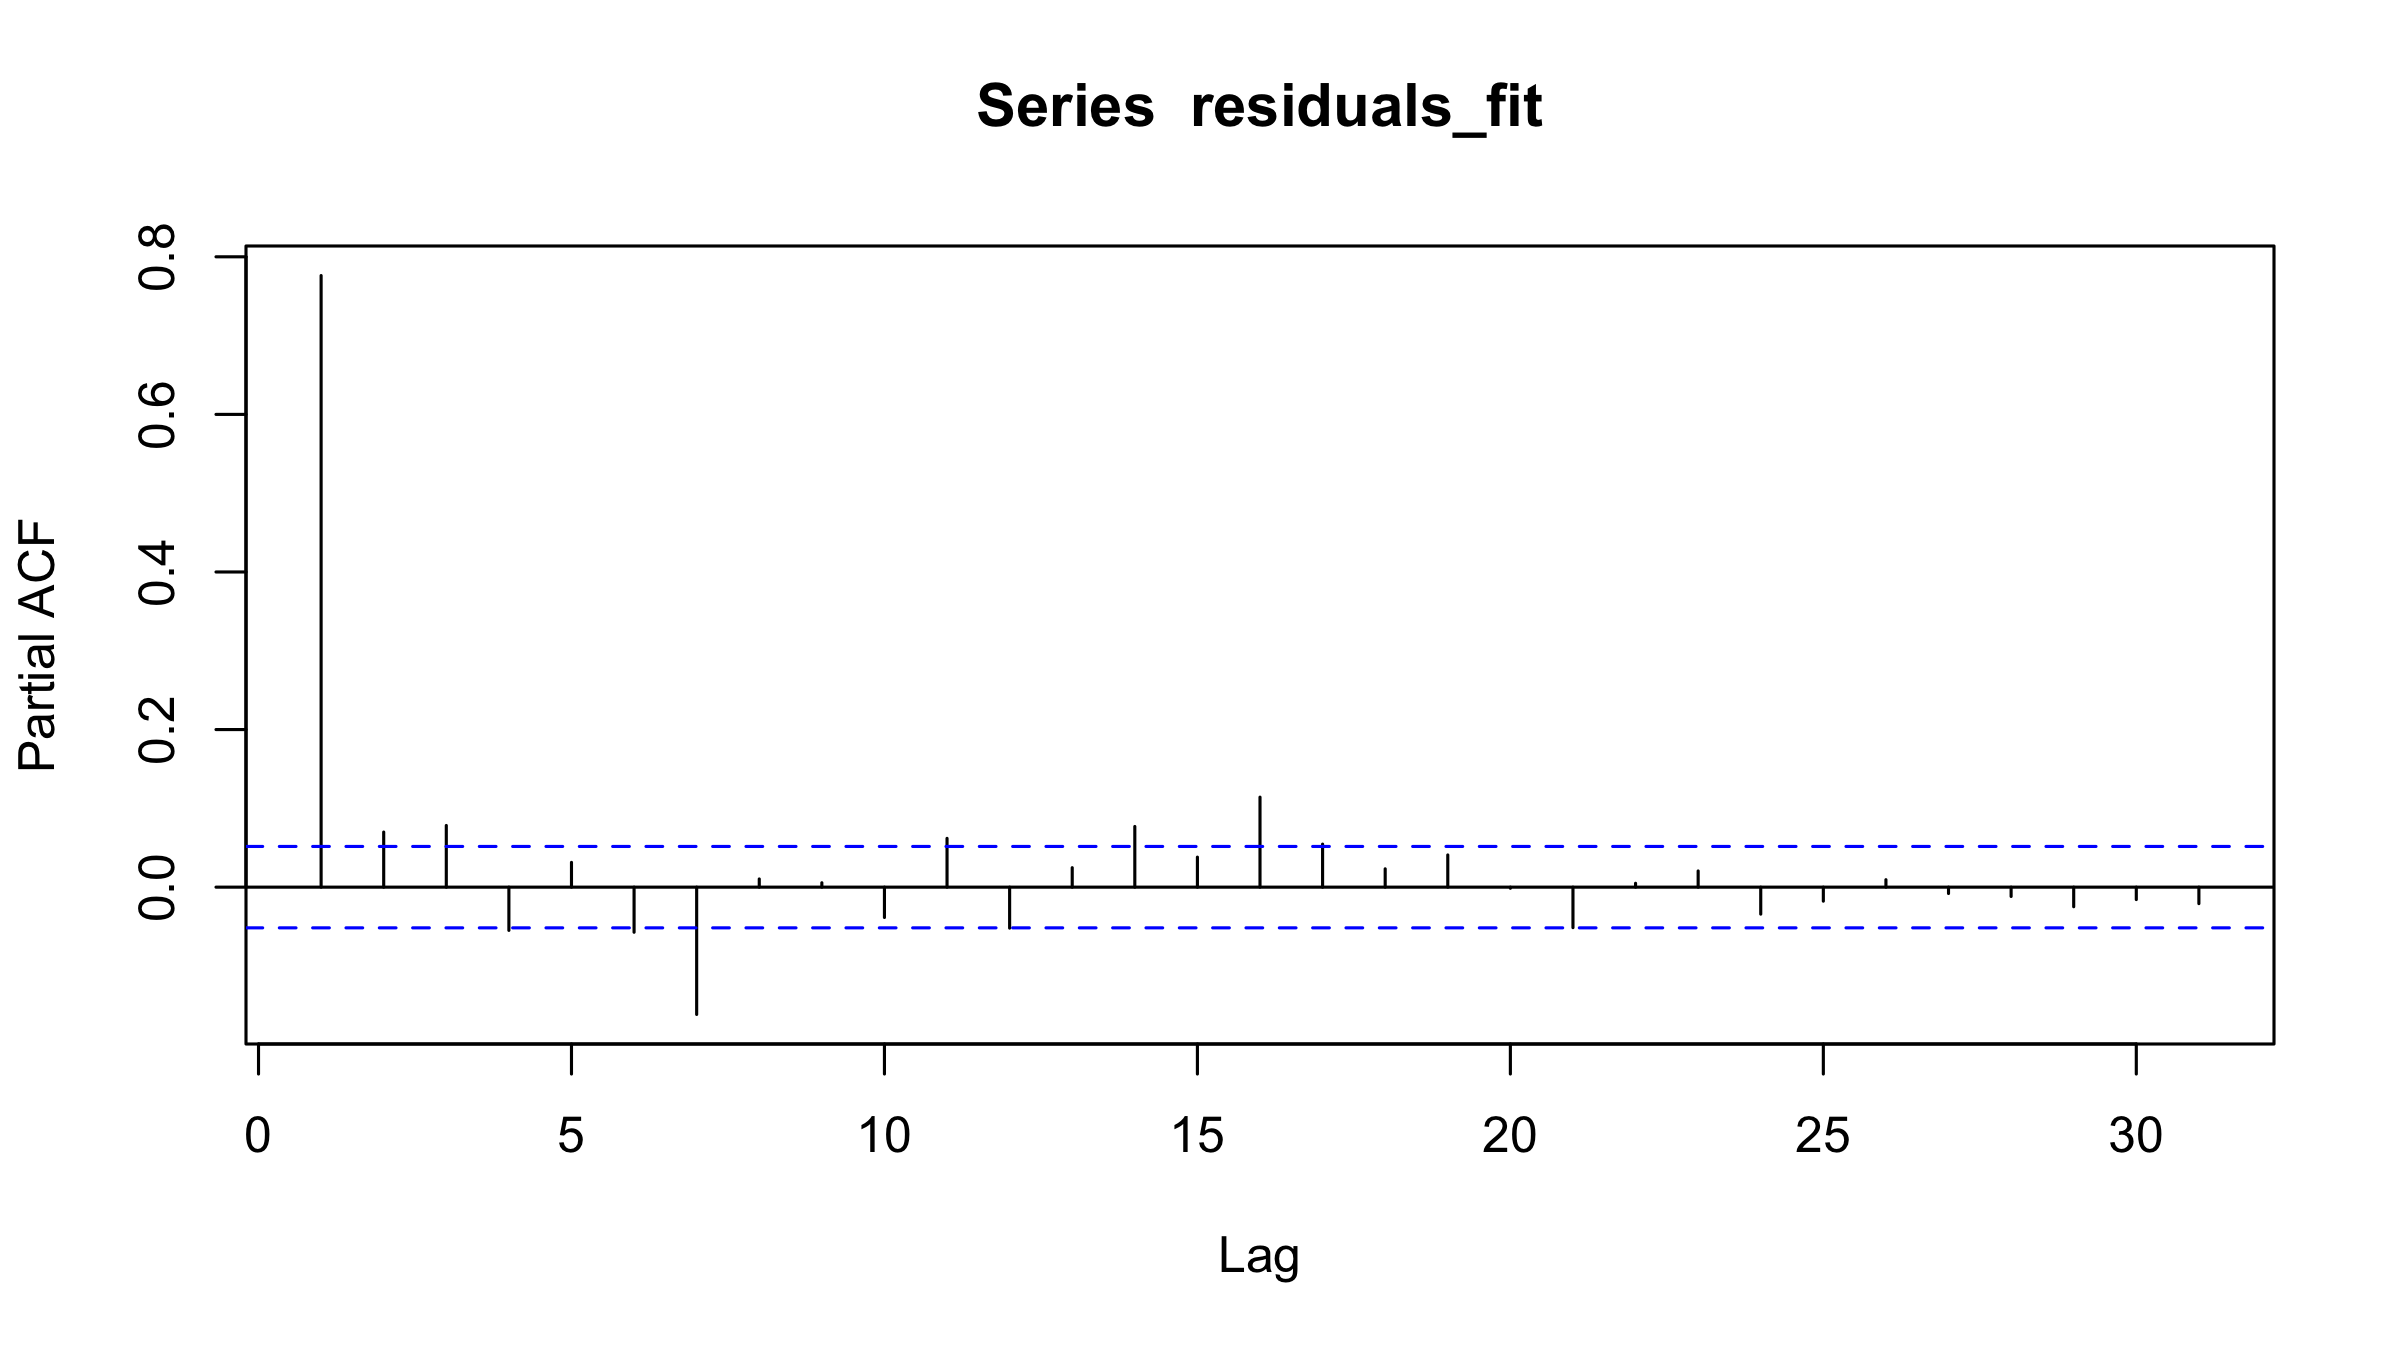

In [29]:
pacf(residuals_fit)

In [65]:
arima_fit = Arima(df_ts, order=c(2,0,0), seasonal = c(1,0,0), include.mean = FALSE)
summary(arima_fit)
residuals_arima_fit = residuals(arima_fit)
ajuste_arima = ts(fitted(arima_fit), start=0, freq=freq)

Series: df_ts 
ARIMA(2,0,0)(1,0,0)[52] with zero mean 

Coefficients:
         ar1     ar2    sar1
      0.8622  0.1062  0.0141
s.e.  0.0063  0.0063  0.0064

sigma^2 = 1311:  log likelihood = -125008.5
AIC=250025.1   AICc=250025.1   BIC=250057.6

Training set error measures:
                   ME     RMSE      MAE MPE MAPE      MASE        ACF1
Training set 3.355079 36.21097 19.61851 NaN  Inf 0.1714609 -0.01437372

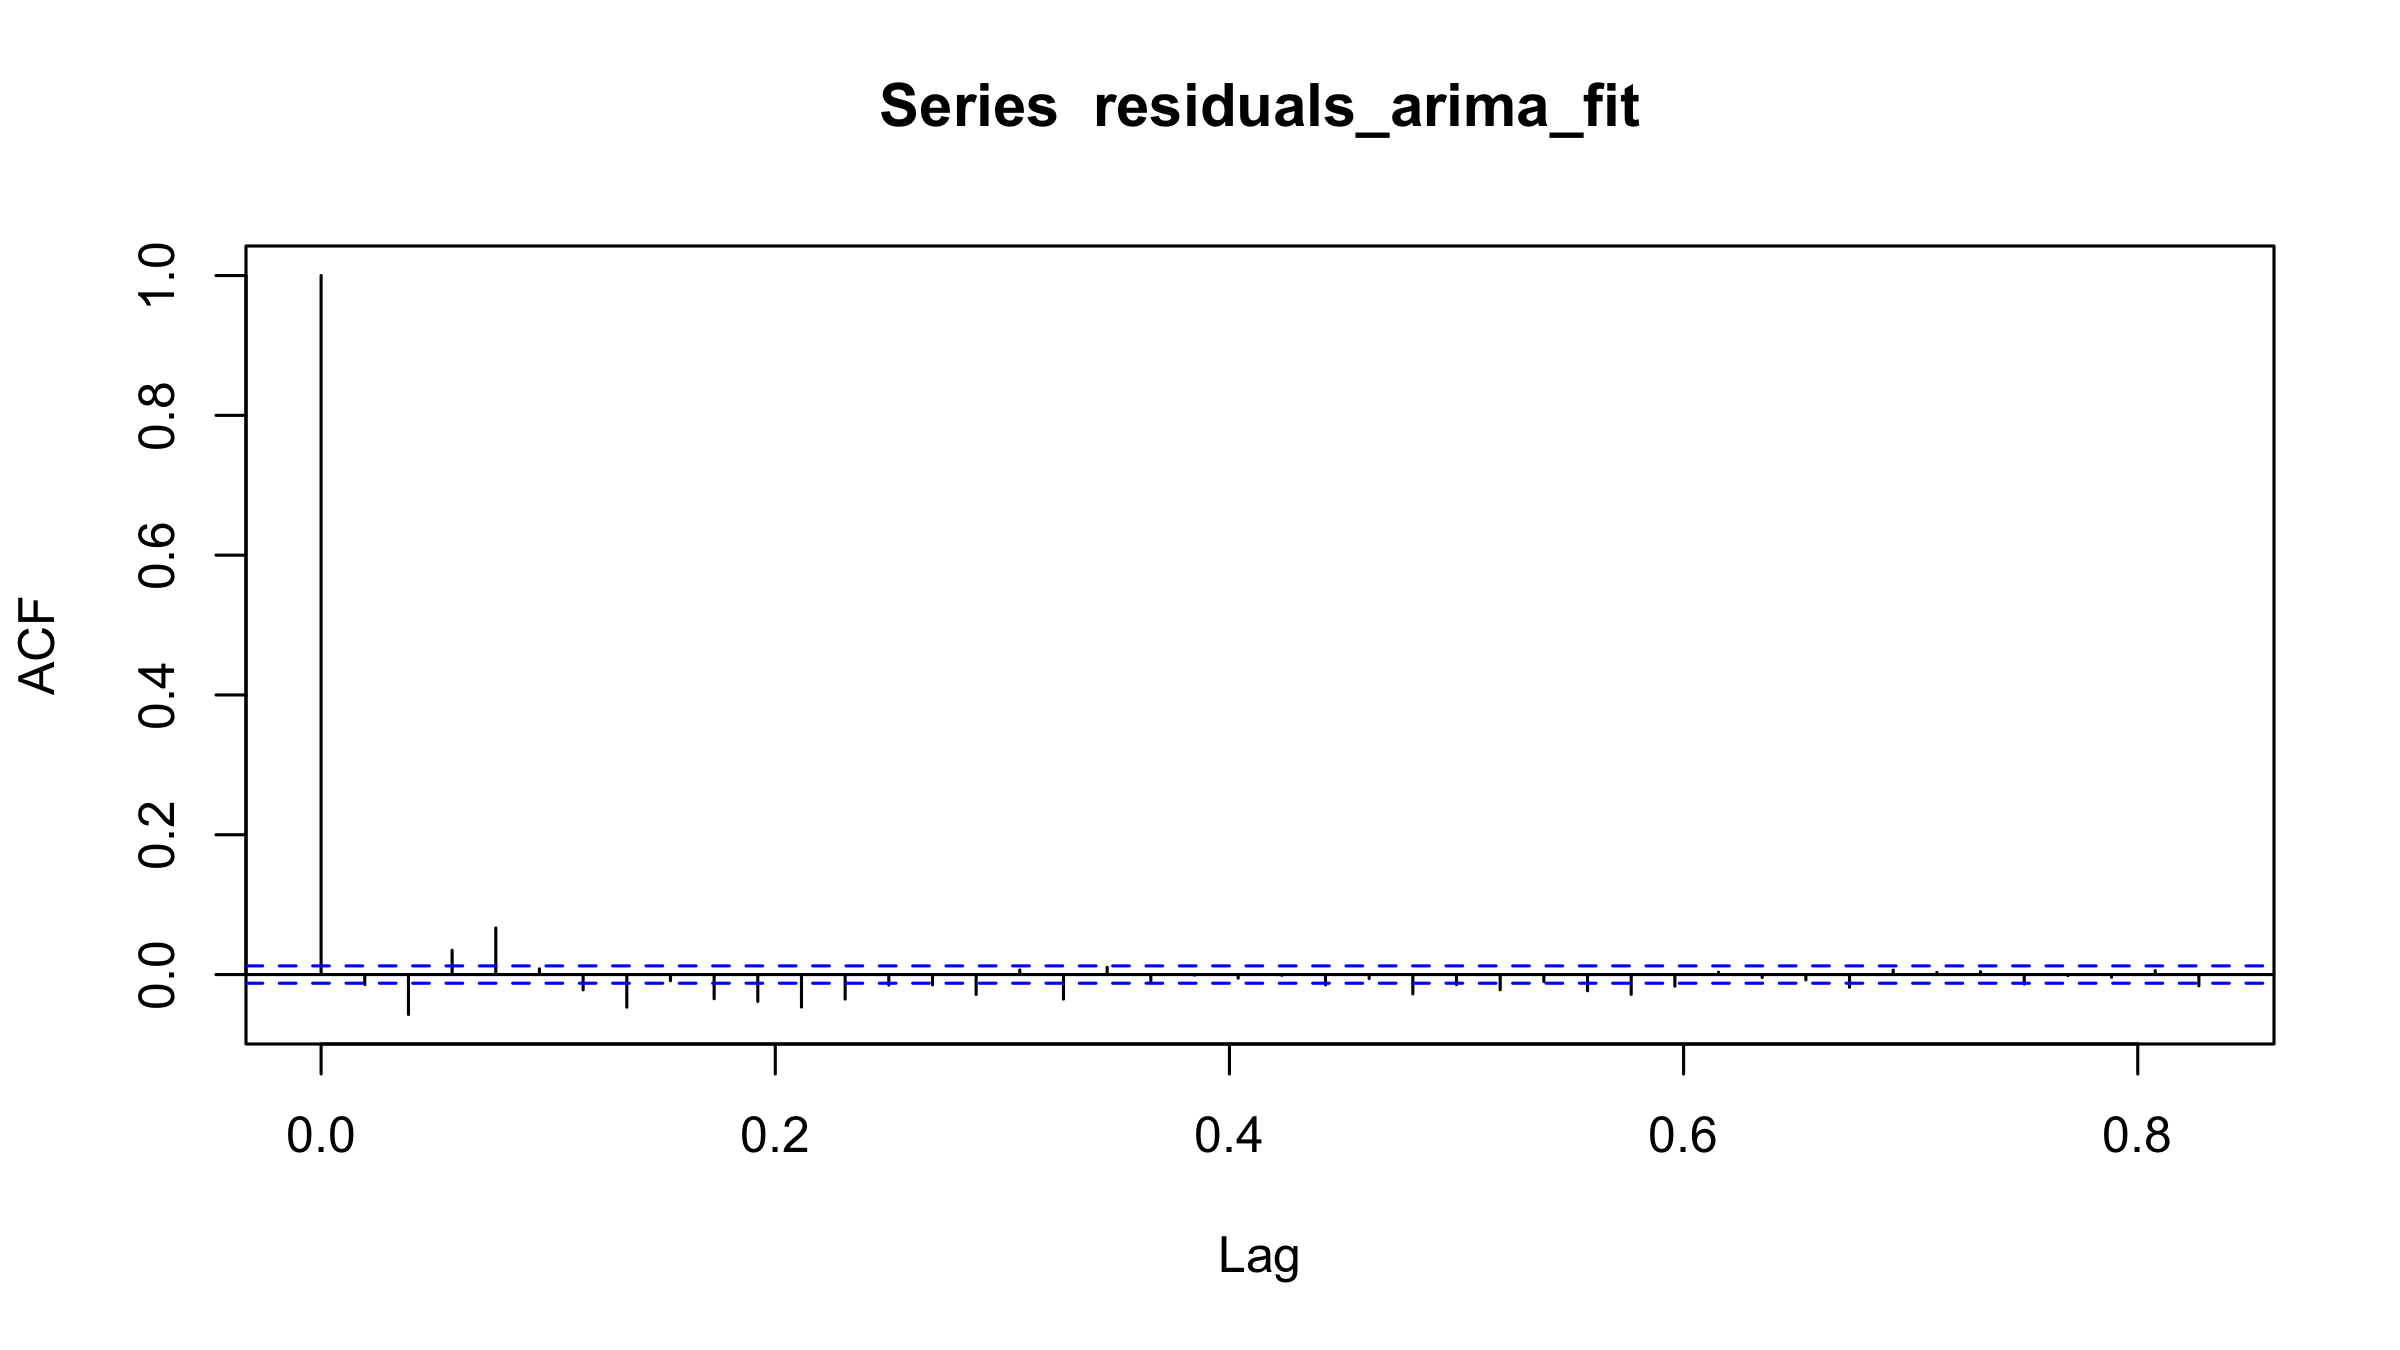

Warning message in modeldf.default(object):
“Could not find appropriate degrees of freedom for this model.”


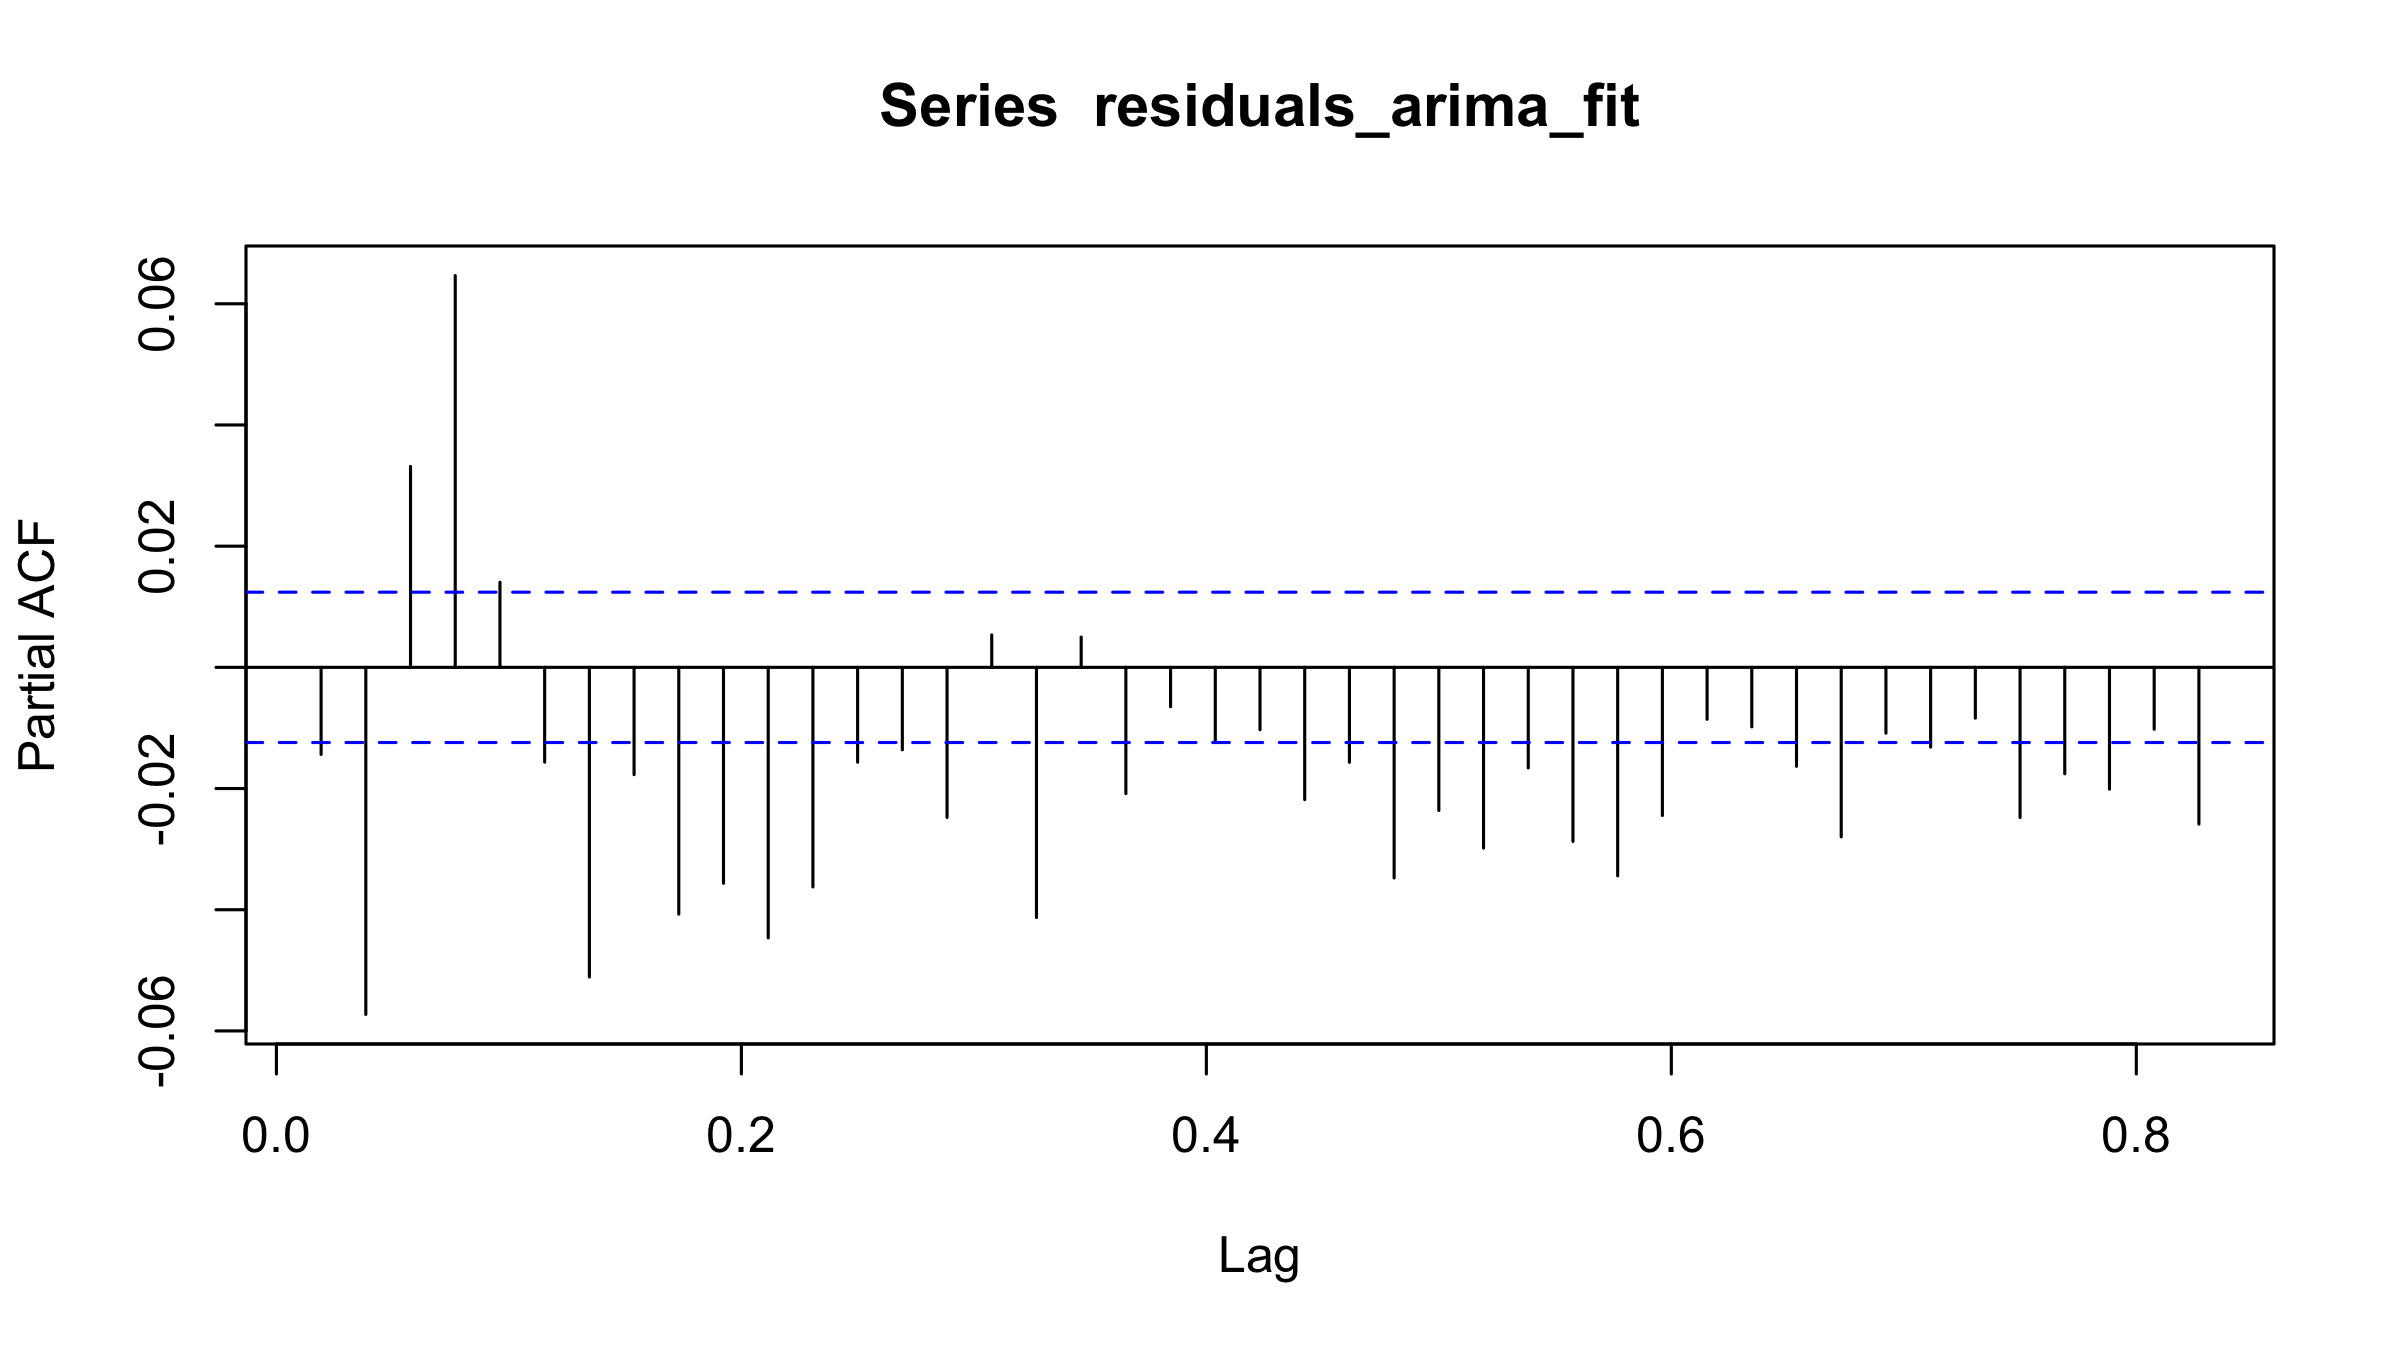

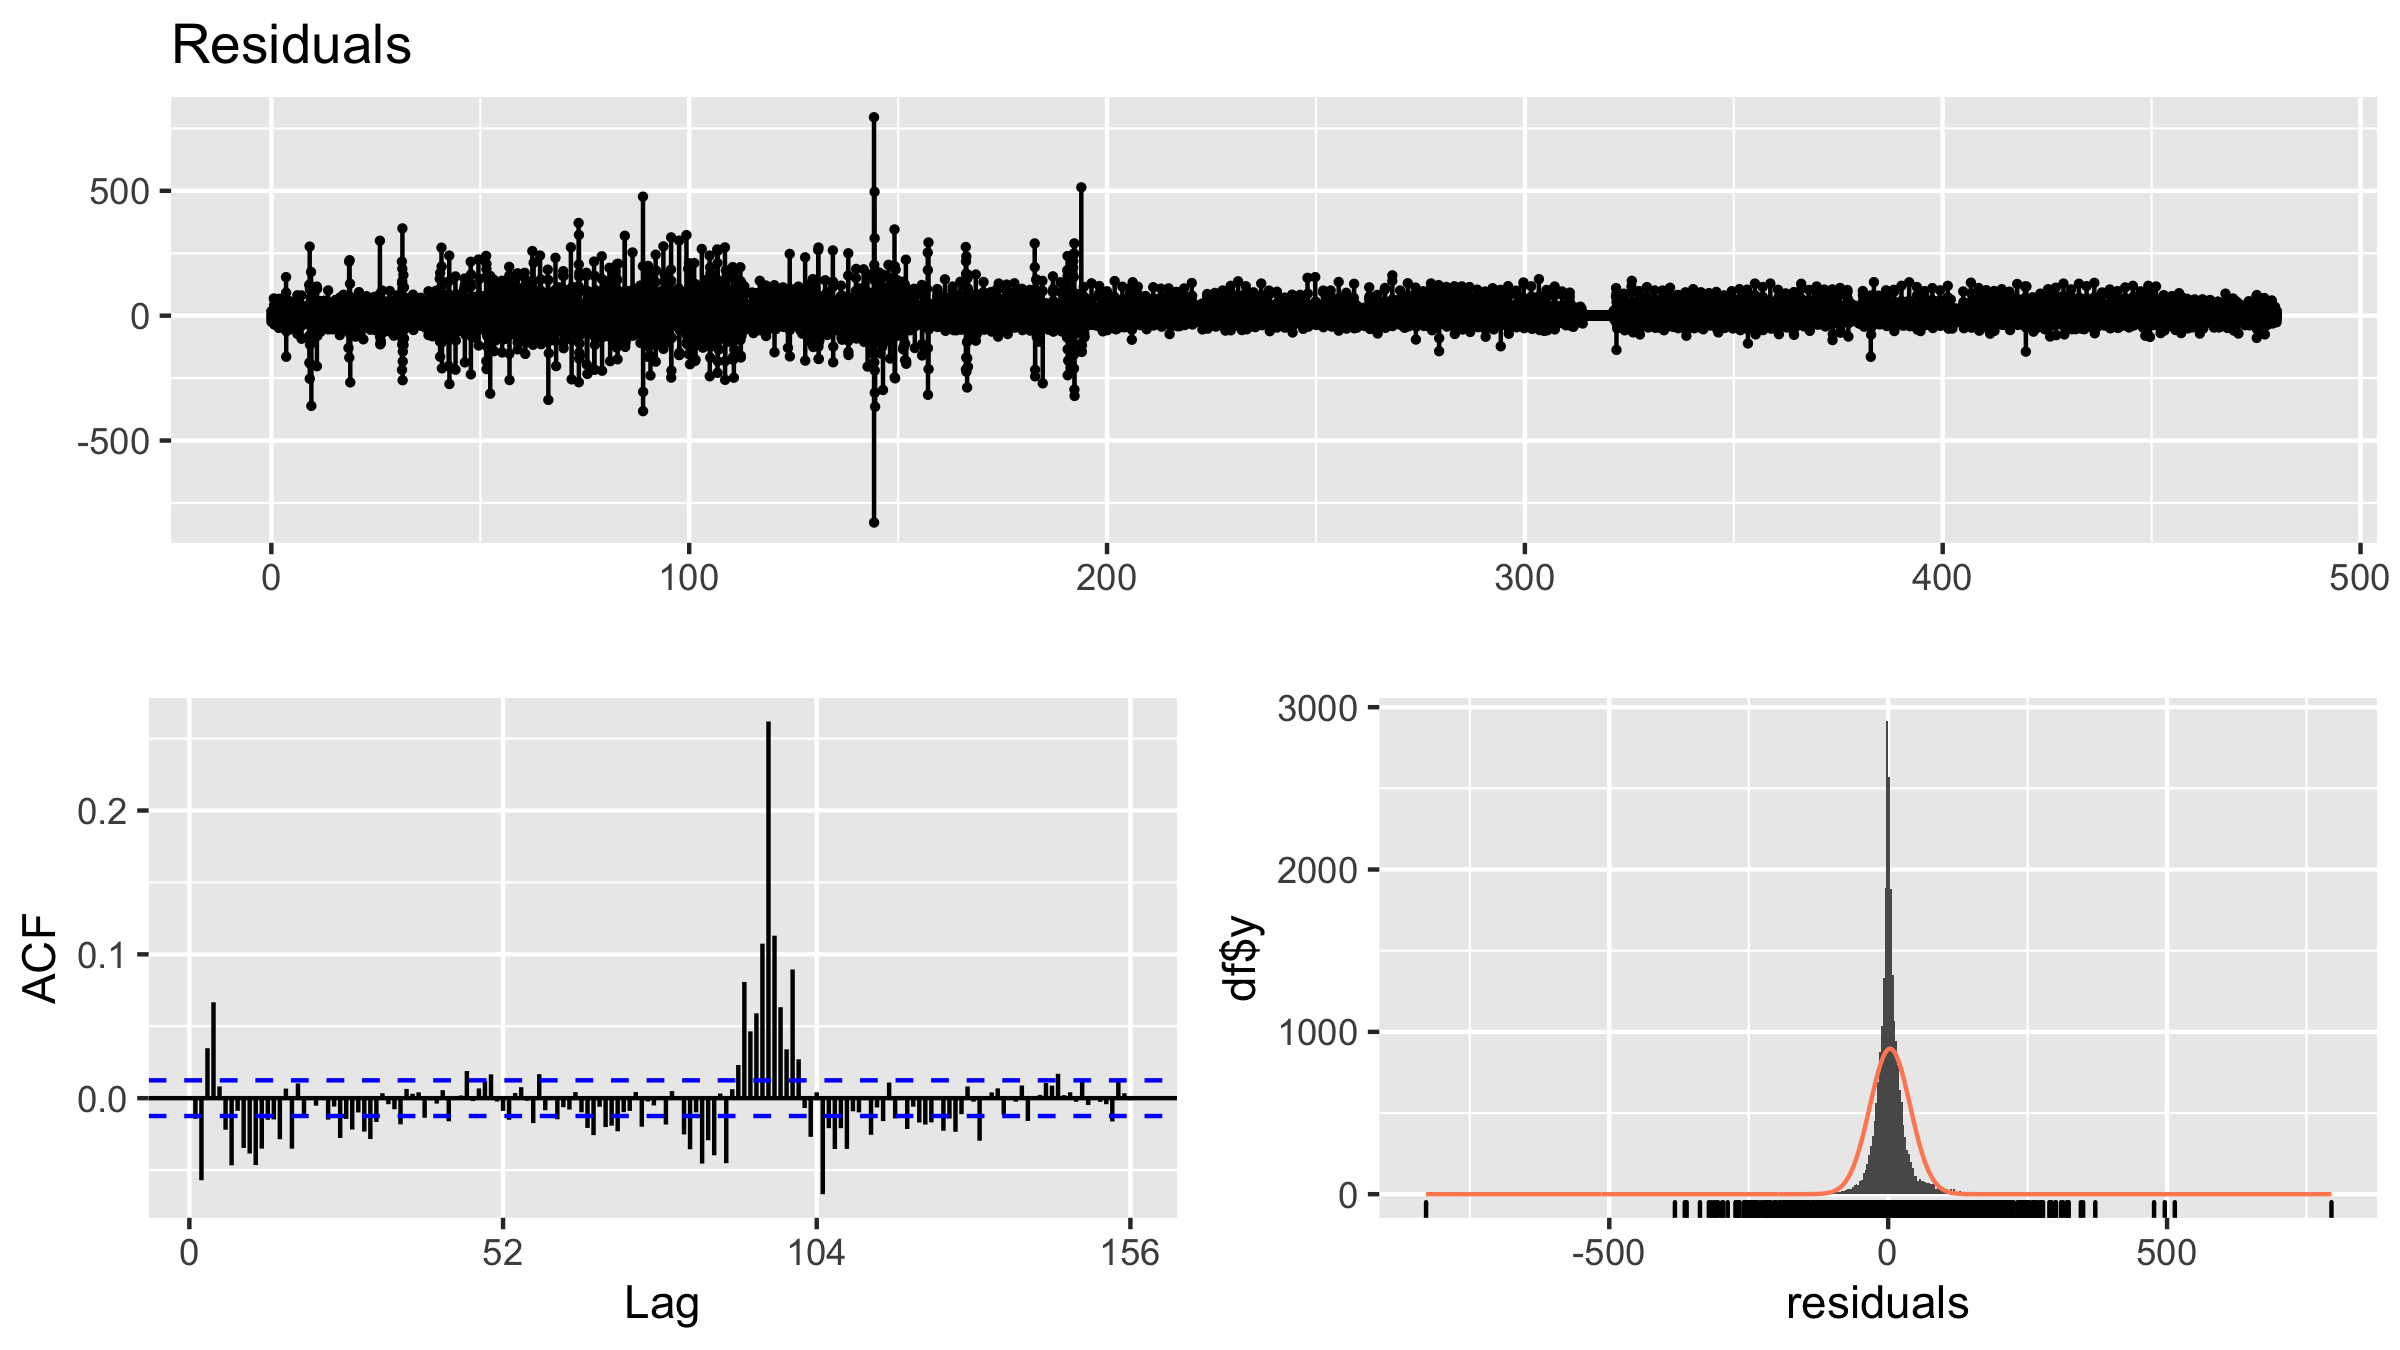

In [66]:
acf(residuals_arima_fit)
pacf(residuals_arima_fit)
checkresiduals(residuals_arima_fit)

In [63]:
autoarima = arima(df_ts_crop)
ajuste_autoarima = ts(fitted(autoarima), start=2017, freq=freq)
summary(autoarima)


Call:
arima(x = df_ts_crop)

Coefficients:
      intercept
        91.5229
s.e.     1.7483

sigma^2 estimated as 4402:  log likelihood = -8083.87,  aic = 16171.74

Training set error measures:
                        ME     RMSE      MAE  MPE MAPE     MASE      ACF1
Training set -2.109551e-14 66.34446 48.47227 -Inf  Inf 2.440232 0.8566258

In [ ]:
autoarima = auto.arima(df_ts, seasonal = TRUE)
ajuste_autoarima = ts(fitted(autoarima), start=2017, freq=freq)
summary(autoarima)

Series: df_ts 
ARIMA(2,1,2) 

Coefficients:
         ar1      ar2      ma1     ma2
      0.5668  -0.5143  -0.7010  0.5455
s.e.  0.0648   0.0277   0.0659  0.0261

sigma^2 = 1317:  log likelihood = -125059.3
AIC=250128.5   AICc=250128.5   BIC=250169.2

Training set error measures:
                       ME     RMSE      MAE MPE MAPE      MASE        ACF1
Training set 0.0004447916 36.29315 19.83495 NaN  Inf 0.1733526 0.002129204